<a href="https://colab.research.google.com/github/yen010390/Classify-the-topic-of-an-article/blob/main/Project_3_1_Classify_the_topic_of_an_article.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1. Th∆∞ vi·ªán**

In [61]:
import os, re, json, random, warnings
from typing import List, Optional
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix, make_scorer
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans

# imbalanced-learn
try:
    from imblearn.over_sampling import SMOTE, RandomOverSampler
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.pipeline import Pipeline as ImbPipeline
    _IMB_OK = True
except Exception:
    _IMB_OK = False
    warnings.warn("imbalanced-learn ch∆∞a c√†i; SMOTE/ROS/RUS s·∫Ω b·ªã t·∫Øt. pip install imbalanced-learn")

warnings.filterwarnings("ignore")

SEED = 42
RANDOM_STATE = 42
CACHE_DIR = "./cache"

In [62]:
def make_splits(
    X, y,
    test_size: float = 0.2,
    val_ratio: float = 0.5,
    seed: int = SEED
):
    """
    Tr·∫£ v·ªÅ: X_train, X_val, X_test, y_train, y_val, y_test
    Test = test_size; Validation = val_ratio tr√™n ph·∫ßn c√≤n l·∫°i.
    """
    X_train, X_tmp, y_train, y_tmp = train_test_split(
        X, y, test_size=test_size, random_state=seed, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_tmp, y_tmp, test_size=val_ratio, random_state=seed, stratify=y_tmp
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

def save_splits(
    X_train, X_val, X_test, y_train, y_val, y_test,
    outdir: str = "splits", target_name: str = "target"
):
    out = Path(outdir); out.mkdir(parents=True, exist_ok=True)
    for name, (X_, y_) in {
        "raw_train": (X_train, y_train),
        "raw_val":   (X_val,   y_val),
        "raw_test":  (X_test,  y_test),
    }.items():
        y_series = pd.Series(y_, name=target_name) if not isinstance(y_, pd.Series) else y_.rename(target_name)
        pd.concat([pd.DataFrame(X_) if not isinstance(X_, pd.DataFrame) else X_, y_series], axis=1) \
          .to_csv(out / f"{name}.csv", index=False)

In [60]:
#T·∫°o block c·∫•u h√¨nh ƒë∆∞·ªùng d·∫´n/ Figure/Report paths
from types import SimpleNamespace

FIG_ROOT = os.path.join("pdf", "Figures")
PATHS = SimpleNamespace(
    root=FIG_ROOT,
    balanced=os.path.join(FIG_ROOT, "balanced"),
    all_models=os.path.join(FIG_ROOT, "all_models"),
)

# T·∫°o th∆∞ m·ª•c
for d in (PATHS.root, PATHS.balanced, PATHS.all_models):
    os.makedirs(d, exist_ok=True)

#**2. X·ª≠ l√Ω d·ªØ li·ªáu**

In [3]:
# Load the dataset from the specified cache directory
ds = load_dataset("UniverseTBD/arxiv-abstracts-large", cache_dir=CACHE_DIR)
ds

README.md:   0%|          | 0.00/810 [00:00<?, ?B/s]

arxiv-metadata-oai-snapshot.json:   0%|          | 0.00/3.82G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2292057 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'],
        num_rows: 2292057
    })
})

In [4]:
all_categories = ds['train']['categories'][:1000]
print(set(all_categories))

{'physics.ed-ph quant-ph', 'math.AP', 'math.PR math.ST stat.TH', 'math.CV math.SP', 'nlin.CD cond-mat.other physics.optics', 'math.AT math.DG', 'math.AP math-ph math.MP', 'cond-mat.supr-con cond-mat.str-el', 'q-bio.BM', 'nucl-th hep-ph', 'physics.gen-ph q-bio.PE', 'math.SG math.AG', 'cond-mat.soft cond-mat.stat-mech', 'math.DG gr-qc', 'cond-mat.mtrl-sci', 'physics.comp-ph physics.chem-ph', 'q-fin.RM math.PR', 'astro-ph gr-qc nucl-th', 'cond-mat.soft', 'q-bio.QM q-bio.MN', 'physics.optics physics.class-ph quant-ph', 'math.AG math.CV', 'math.LO math.CO', 'cond-mat.other', 'cond-mat.stat-mech cond-mat.soft', 'math.AG', 'hep-ph hep-ex nucl-ex', 'math.CO math.AC math.AG', 'quant-ph', 'physics.bio-ph', 'math.AG math.ST stat.TH', 'math.DG', 'math-ph math.GT math.MP', 'cond-mat.mtrl-sci cond-mat.other', 'math.DS', 'quant-ph hep-th', 'physics.optics physics.class-ph', 'math-ph hep-th math.MP', 'nucl-ex', 'physics.plasm-ph', 'cond-mat.stat-mech math-ph math.MP', 'cond-mat.str-el cond-mat.supr-co

In [5]:
all_categories = ds['train']['categories']
category_set = set()

# Collect unique labels
for category in all_categories:
    parts = category.split(' ')
    for part in parts:
        topic = part.split('.')[0]
        category_set.add(topic)

# Sort the labels and print them
sorted_categories= sorted(list(category_set), key=lambda x: x.lower())
print(f'There are {len(sorted_categories)} unique primary categories in the dataset:')
for category in sorted_categories:
    print(category)

There are 38 unique primary categories in the dataset:
acc-phys
adap-org
alg-geom
ao-sci
astro-ph
atom-ph
bayes-an
chao-dyn
chem-ph
cmp-lg
comp-gas
cond-mat
cs
dg-ga
econ
eess
funct-an
gr-qc
hep-ex
hep-lat
hep-ph
hep-th
math
math-ph
mtrl-th
nlin
nucl-ex
nucl-th
patt-sol
physics
plasm-ph
q-alg
q-bio
q-fin
quant-ph
solv-int
stat
supr-con


In [6]:
# load 1000 samples with single label belonging to specific categories
samples = []
CATEGORIES_TO_SELECT = ['astro-ph', 'cond-mat', 'cs', 'math', 'physics']
for s in ds['train']:
    if len(s['categories'].split(' ')) != 1:
        continue

    cur_category = s['categories'].strip().split('.')[0]
    if cur_category not in CATEGORIES_TO_SELECT:
        continue

    samples.append(s)

    if len(samples) >= 1000:
        break
print(f"Number of samples: {len(samples)}")

for sample in samples[:3]:
    print(f"Category: {sample['categories']}")
    print("Abstract:", sample['abstract'])
    print("#" * 20 + "\n")

Number of samples: 1000
Category: physics.gen-ph
Abstract:   The evolution of Earth-Moon system is described by the dark matter field
fluid model proposed in the Meeting of Division of Particle and Field 2004,
American Physical Society. The current behavior of the Earth-Moon system agrees
with this model very well and the general pattern of the evolution of the
Moon-Earth system described by this model agrees with geological and fossil
evidence. The closest distance of the Moon to Earth was about 259000 km at 4.5
billion years ago, which is far beyond the Roche's limit. The result suggests
that the tidal friction may not be the primary cause for the evolution of the
Earth-Moon system. The average dark matter field fluid constant derived from
Earth-Moon system data is 4.39 x 10^(-22) s^(-1)m^(-1). This model predicts
that the Mars's rotation is also slowing with the angular acceleration rate
about -4.38 x 10^(-22) rad s^(-2).

####################

Category: math.CO
Abstract:   We show 

In [7]:
preprocessed_samples = []
for s in samples:
    abstract = s['abstract']

    # Remove \n characters in the middle and leading/trailing spaces
    abstract = abstract.strip().replace("\n", " ")

    # Remove special characters
    abstract = re.sub(r'[^\w\s]', '', abstract)

    # Remove digits
    abstract = re.sub(r'\d+', '', abstract)

    # Remove extra spaces
    abstract = re.sub(r'\s+', ' ', abstract).strip()

    # Convert to lower case
    abstract = abstract.lower()

    # for the label, we only keep the first part
    parts = s['categories'].split(' ')
    category = parts[0].split('.')[0]

    preprocessed_samples.append({
        "text": abstract,
        "label": category
    })

# print first 3 preprocessed samples
for sample in preprocessed_samples[:3]:
    print(f"Label: {sample['label']}")
    print("Text:", sample['text'])
    print("#" * 20 + "\n")

Label: physics
Text: the evolution of earthmoon system is described by the dark matter field fluid model proposed in the meeting of division of particle and field american physical society the current behavior of the earthmoon system agrees with this model very well and the general pattern of the evolution of the moonearth system described by this model agrees with geological and fossil evidence the closest distance of the moon to earth was about km at billion years ago which is far beyond the roches limit the result suggests that the tidal friction may not be the primary cause for the evolution of the earthmoon system the average dark matter field fluid constant derived from earthmoon system data is x sm this model predicts that the marss rotation is also slowing with the angular acceleration rate about x rad s
####################

Label: math
Text: we show that a determinant of stirling cycle numbers counts unlabeled acyclic singlesource automata the proof involves a bijection from 

In [8]:
labels = set([s['label'] for s in preprocessed_samples])
# Sort and print unique labels
sorted_labels = sorted(labels)
for label in sorted_labels:
    print(label)

astro-ph
cond-mat
cs
math
physics


In [9]:
label_to_id = {label: i for i, label in enumerate(sorted_labels)}
id_to_label = {i: label for i, label in enumerate(sorted_labels)}

# Print label to ID mapping
print("Label to ID mapping:")
for label, id_ in label_to_id.items():
    print(f"{label} --> {id_}")

Label to ID mapping:
astro-ph --> 0
cond-mat --> 1
cs --> 2
math --> 3
physics --> 4


In [10]:
X_full = [sample['text'] for sample in preprocessed_samples]
y_full = [label_to_id[sample['label']] for sample in preprocessed_samples]

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42, stratify=y_full)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 800
Test samples: 200


In [11]:
if 'preprocessor' not in globals():
    print("‚ÑπÔ∏è Kh√¥ng th·∫•y `preprocessor`, t·∫°o nhanh preprocessor m·∫∑c ƒë·ªãnh.")
    numerical_cols = ['age','trestbps','chol','thalach','oldpeak']
    categorical_cols = ['sex','cp','fbs','restecg','exang','slope','ca','thal']
    try:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([('imputer', SimpleImputer(strategy='median')),
                              ('scaler', StandardScaler())]), numerical_cols),
            ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                              ('ohe', ohe)]), categorical_cols)
        ]
    )

‚ÑπÔ∏è Kh√¥ng th·∫•y `preprocessor`, t·∫°o nhanh preprocessor m·∫∑c ƒë·ªãnh.


# **3. TƒÉng c∆∞·ªùng d·ªØ li·ªáu**

In [12]:
# üîÅ Data Augmentation + Class-Balanced Upsampling (put this right after train_test_split)

# ‚öôÔ∏è Config
AUGMENT_ENABLED      = True      # t·∫Øt/m·ªü augmentation
TARGET_PER_CLASS     = 300       # m·ªói l·ªõp s·∫Ω ƒë∆∞·ª£c tƒÉng l√™n t·ªëi ƒëa m·ª©c n√†y (ho·∫∑c max hi·ªán c√≥, tu·ª≥ l·ªõp)
ALPHA_DELETE         = 0.10      # x√°c su·∫•t xo√° t·ª´
ALPHA_SWAP           = 0.10      # t·ª∑ l·ªá ho√°n v·ªã ~ (ALPHA_SWAP * s·ªë t·ª´)
ALPHA_SYNONYM_RATIO  = 0.10      # t·ª∑ l·ªá t·ª´ s·∫Ω ƒë∆∞·ª£c thay b·∫±ng ƒë·ªìng nghƒ©a (n·∫øu c√≥ wordnet)
NUM_AUG_PER_SAMPLE   = 1         # m·ªói vƒÉn b·∫£n g·ªëc sinh ra bao nhi√™u bi·∫øn th·ªÉ
RANDOM_SEED          = 42

random.seed(RANDOM_SEED)

#WordNet synonyms
try:
    import nltk
    nltk.data.find('corpora/wordnet')
except Exception:
    try:
        import nltk
        nltk.download('wordnet', quiet=True)
        nltk.download('omw-1.4', quiet=True)
    except Exception:
        pass

try:
    from nltk.corpus import wordnet as wn
    _WORDNET_OK = True
except Exception:
    _WORDNET_OK = False

def _tokenize_simple(s: str) -> List[str]:
    return s.split()

def _random_deletion(tokens: List[str], p: float) -> List[str]:
    if not tokens:
        return tokens
    out = [t for t in tokens if random.random() > p]
    return out if out else tokens  # kh√¥ng ƒë·ªÉ r·ªóng

def _random_swap(tokens: List[str], n_swaps: int) -> List[str]:
    if len(tokens) < 2 or n_swaps <= 0:
        return tokens
    tokens = tokens.copy()
    for _ in range(n_swaps):
        i, j = random.sample(range(len(tokens)), 2)
        tokens[i], tokens[j] = tokens[j], tokens[i]
    return tokens

def _get_synonyms(word: str) -> List[str]:
    if not _WORDNET_OK or not word.isalpha():
        return []
    syns = set()
    for syn in wn.synsets(word):
        for lem in syn.lemmas():
            w = lem.name().replace('_', ' ').lower()
            if w != word:
                syns.add(w)
    return list(syns)

def _random_synonym_replace(tokens: List[str], ratio: float) -> List[str]:
    if not _WORDNET_OK or ratio <= 0 or not tokens:
        return tokens
    tokens = tokens.copy()
    n_changes = max(1, int(len(tokens) * ratio))
    idxs = list(range(len(tokens)))
    random.shuffle(idxs)
    changed = 0
    for i in idxs:
        syns = _get_synonyms(tokens[i])
        if syns:
            tokens[i] = random.choice(syns)
            changed += 1
        if changed >= n_changes:
            break
    return tokens

def eda_augment(text: str,
                alpha_del=ALPHA_DELETE,
                alpha_swap=ALPHA_SWAP,
                alpha_syn=ALPHA_SYNONYM_RATIO,
                num_aug=NUM_AUG_PER_SAMPLE) -> List[str]:
    """
    EDA c∆° b·∫£n: xo√°, ho√°n v·ªã, thay t·ª´ ƒë·ªìng nghƒ©a (n·∫øu c√≥).
    """
    out = []
    base_tokens = _tokenize_simple(text)
    for _ in range(num_aug):
        tokens = base_tokens
        # xo√° ng·∫´u nhi√™n
        tokens = _random_deletion(tokens, alpha_del)
        # ho√°n v·ªã ng·∫´u nhi√™n
        n_swaps = max(1, int(len(tokens) * alpha_swap)) if len(tokens) > 1 else 0
        tokens = _random_swap(tokens, n_swaps)
        # thay t·ª´ ƒë·ªìng nghƒ©a
        tokens = _random_synonym_replace(tokens, alpha_syn)
        out.append(' '.join(tokens))
    return out

def augment_and_balance(X_train: List[str],
                        y_train: List[int],
                        target_per_class: int = TARGET_PER_CLASS,
                        seed: int = RANDOM_SEED):
    """
    TƒÉng c∆∞·ªùng + c√¢n b·∫±ng theo l·ªõp cho t·ªõi khi m·ªói l·ªõp ƒë·∫°t √≠t nh·∫•t target_per_class
    (ho·∫∑c t·ªõi m·ª©c g·∫ßn nh·∫•t c√≥ th·ªÉ).
    """
    random.seed(seed)
    X_train = list(X_train)
    y_train = list(y_train)

    counts = Counter(y_train)
    classes = sorted(counts.keys())
    cur_max = max(counts.values()) if counts else 0
    target = max(min(target_per_class, max(cur_max, 1)), 1)

    # Gom vƒÉn b·∫£n theo l·ªõp
    by_class = {c: [x for x, y in zip(X_train, y_train) if y == c] for c in classes}

    X_aug, y_aug = [], []
    for c in classes:
        texts = by_class[c]
        need = max(0, target - len(texts))
        if need == 0 or not texts:
            continue

        # L·∫∑p qua vƒÉn b·∫£n g·ªëc, sinh bi·∫øn th·ªÉ cho t·ªõi khi ƒë·ªß
        i = 0
        while need > 0:
            t = texts[i % len(texts)]
            for aug in eda_augment(t):
                X_aug.append(aug)
                y_aug.append(c)
                need -= 1
                if need <= 0:
                    break
            i += 1

    # Gh√©p v√†o train
    X_new = X_train + X_aug
    y_new = y_train + y_aug

    after = Counter(y_new)
    print("üîß Augmented per-class counts:", dict(after))
    print(f"üîº Train size: {len(X_train)} ‚Üí {len(X_new)} (added {len(X_aug)})")
    return X_new, y_new

# Th·ª±c thi augmentation (n·∫øu b·∫≠t)
if AUGMENT_ENABLED:
    X_train, y_train = augment_and_balance(
        X_train, y_train, target_per_class=TARGET_PER_CLASS, seed=RANDOM_SEED
    )
else:
    print("Augmentation disabled ‚Äî skipping.")

üîß Augmented per-class counts: {1: 300, 0: 347, 4: 300, 3: 300, 2: 300}
üîº Train size: 800 ‚Üí 1547 (added 747)


In [13]:
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow  = bow_vectorizer.transform(X_test)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf  = tfidf_vectorizer.transform(X_test)

In [65]:
#EmbeddingVectorizer
class EmbeddingVectorizer:
    def __init__(self, model_name: str = "intfloat/multilingual-e5-base",
                 normalize: bool = True, device: Optional[str] = None):
        self.model = SentenceTransformer(model_name, device=device)
        self.normalize = normalize

    def _format_inputs(self, texts: List[str], mode: str = "query") -> List[str]:
        if mode == "raw":
            return texts
        if mode not in {"query", "passage"}:
            raise ValueError("mode ph·∫£i l√† 'query', 'passage' ho·∫∑c 'raw'")
        return [f"{mode}: {t.strip()}" for t in texts]

    def transform_numpy(self, texts: List[str], mode: str = "query") -> np.ndarray:
        inputs = self._format_inputs(texts, mode)
        embs = self.model.encode(inputs,
                                 normalize_embeddings=self.normalize,
                                 convert_to_numpy=True,
                                 batch_size=64,
                                 show_progress_bar=False)
        return embs

In [15]:
#T·∫°o embedding
embedding_vectorizer = EmbeddingVectorizer()  # m·∫∑c ƒë·ªãnh 'intfloat/multilingual-e5-base'
X_train_embeddings = embedding_vectorizer.transform_numpy(X_train)  # shape (N, 768)
X_test_embeddings  = embedding_vectorizer.transform_numpy(X_test)

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

# **4. C√¢n b·∫±ng d·ªØ li·ªáu train**

In [66]:
BALANCE_BOW      = "over"   # 'none' | 'over' | 'under'  (kh√¥ng khuy·∫øn ngh·ªã 'smote' cho sparse)
BALANCE_TFIDF    = "over"   # 'none' | 'over' | 'under'
BALANCE_EMB      = "smote"  # 'none' | 'over' | 'under' | 'smote' (SMOTE t·ªët cho embeddings)

def _print_counts(y, note):
    cnt = Counter(y)
    print(f"{note} ‚Äî s·ªë m·∫´u theo l·ªõp:", dict(sorted(cnt.items())))

def _fallback_resample_over(X, y):
    y = np.asarray(y)
    classes, counts = np.unique(y, return_counts=True)
    max_count = counts.max()
    idx_all = np.arange(len(y))
    idx_new = np.concatenate([
        np.tile(idx_all[y == c], int(np.ceil(max_count / (y == c).sum())))[:max_count]
        for c in classes
    ])
    X_new = X[idx_new] if hasattr(X, "shape") or hasattr(X, "toarray") else [X[i] for i in idx_new]
    return X_new, y[idx_new]

def _fallback_resample_under(X, y):
    y = np.asarray(y)
    classes, counts = np.unique(y, return_counts=True)
    min_count = counts.min()
    rng = np.random.default_rng(SEED)
    idx_new = np.concatenate([
        rng.choice(np.where(y == c)[0], size=min_count, replace=False)
        for c in classes
    ])
    rng.shuffle(idx_new)
    X_new = X[idx_new] if hasattr(X, "shape") or hasattr(X, "toarray") else [X[i] for i in idx_new]
    return X_new, y[idx_new]

def make_balanced(X, y, strategy: str, for_embeddings: bool = False):
    """
    strategy: 'none' | 'over' | 'under' | 'smote'
    for_embeddings: True n·∫øu l√† embeddings (dense) => cho ph√©p SMOTE
    T·ª± suy ra sparse/dense t·ª´ X (kh√¥ng c·∫ßn truy·ªÅn is_sparse).
    """
    if strategy == "none":
        return X, y

    is_sparse = hasattr(X, "toarray")  # scipy sparse c√≥ .toarray
    if strategy == "smote":
        # ch·ªâ ch·∫•p nh·∫≠n cho embeddings (dense) v√† khi c√≥ imblearn
        if not for_embeddings or is_sparse or not _IMB_OK:
            print("‚ö†Ô∏è SMOTE kh√¥ng √°p d·ª•ng cho sparse ho·∫∑c khi thi·∫øu imblearn ‚Üí d√πng 'over'.")
            strategy = "over"

    if not _IMB_OK and strategy in {"over", "under"}:
        return _fallback_resample_over(X, y) if strategy == "over" else _fallback_resample_under(X, y)

    if strategy in {"over", "under"} and _IMB_OK:
        sampler = (RandomOverSampler if strategy == "over" else RandomUnderSampler)(random_state=SEED)
        y_arr = np.asarray(y)
        X_bal, y_bal = sampler.fit_resample(X, y_arr)
        return X_bal, y_bal

    if strategy == "smote":  # embeddings + imblearn
        y_arr = np.asarray(y)
        X_bal, y_bal = SMOTE(random_state=SEED, k_neighbors=5).fit_resample(X, y_arr)
        return X_bal, y_bal

    return X, y

In [67]:
# ===== Th·ª±c thi c√¢n b·∫±ng =====
_print_counts(y_train, "Tr∆∞·ªõc c√¢n b·∫±ng")

X_train_bow_bal,   y_train_bow_bal   = make_balanced(X_train_bow,   y_train, strategy=BALANCE_BOW,   for_embeddings=False)
_print_counts(y_train_bow_bal,   f"BoW sau c√¢n b·∫±ng ({BALANCE_BOW})")

X_train_tfidf_bal, y_train_tfidf_bal = make_balanced(X_train_tfidf, y_train, strategy=BALANCE_TFIDF, for_embeddings=False)
_print_counts(y_train_tfidf_bal, f"TF-IDF sau c√¢n b·∫±ng ({BALANCE_TFIDF})")

X_train_emb_bal,   y_train_emb_bal   = make_balanced(X_train_embeddings, y_train, strategy=BALANCE_EMB, for_embeddings=True)
_print_counts(y_train_emb_bal,   f"Embeddings sau c√¢n b·∫±ng ({BALANCE_EMB})")

Tr∆∞·ªõc c√¢n b·∫±ng ‚Äî s·ªë m·∫´u theo l·ªõp: {0: 347, 1: 300, 2: 300, 3: 300, 4: 300}
BoW sau c√¢n b·∫±ng (over) ‚Äî s·ªë m·∫´u theo l·ªõp: {np.int64(0): 347, np.int64(1): 347, np.int64(2): 347, np.int64(3): 347, np.int64(4): 347}
TF-IDF sau c√¢n b·∫±ng (over) ‚Äî s·ªë m·∫´u theo l·ªõp: {np.int64(0): 347, np.int64(1): 347, np.int64(2): 347, np.int64(3): 347, np.int64(4): 347}
Embeddings sau c√¢n b·∫±ng (smote) ‚Äî s·ªë m·∫´u theo l·ªõp: {np.int64(0): 347, np.int64(1): 347, np.int64(2): 347, np.int64(3): 347, np.int64(4): 347}


# **5. Hu·∫•n luy·ªán l·∫°i tr√™n t·∫≠p ƒë√£ c√¢n b·∫±ng**


In [64]:
# üéØ Confusion matrices ‚Äî Sau c√¢n b·∫±ng
if 'sorted_labels' not in globals():
    uniq = sorted(set(y_test))
    sorted_labels = [str(i) for i in uniq]
labels_idx = list(range(len(sorted_labels)))

# ===== Ki·ªÉm tra bi·∫øn c·∫ßn thi·∫øt (fail s·ªõm) =====
_required = [
    'X_train_bow_bal','y_train_bow_bal','X_test_bow',
    'X_train_tfidf_bal','y_train_tfidf_bal','X_test_tfidf',
    'X_train_emb_bal','y_train_emb_bal','X_test_embeddings',
    'y_test'
]
_missing = [v for v in _required if v not in globals()]
assert not _missing, f"Thi·∫øu bi·∫øn: {_missing}. H√£y ch·∫°y cell ti·ªÅn x·ª≠ l√Ω / vector h√≥a tr∆∞·ªõc."

# ===== Helpers chung =====
if 'cv' not in globals():
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

if 'f1_scorer' not in globals():
    f1_scorer = make_scorer(f1_score, average='macro')

def _to_dense(X):
    """√âp dense cho GaussianNB/khi c·∫ßn."""
    return X.toarray() if hasattr(X, "toarray") else X

def _safe_report(y_true, y_pred):
    return classification_report(y_true, y_pred, target_names=sorted_labels, output_dict=True)

def _summarize(name, y_true, y_pred):
    return dict(
        model_feature=name,
        accuracy=accuracy_score(y_true, y_pred),
        f1_macro=f1_score(y_true, y_pred, average="macro"),
        f1_weighted=f1_score(y_true, y_pred, average="weighted"),
    )

def plot_cv_curve(xs, ys, xlabel, title, semilog=False):
    plt.figure(figsize=(6,4))
    (plt.semilogx if semilog else plt.plot)(xs, ys, marker='o')
    plt.xlabel(xlabel); plt.ylabel('CV F1 (macro)')
    plt.title(title); plt.grid(True, alpha=.3)
    plt.tight_layout(); plt.show()

# # ========= Tabular preprocessor & make_clf_pipe=========
# def default_preprocessor():
#     """T·∫°o ColumnTransformer m·∫∑c ƒë·ªãnh cho d·ªØ li·ªáu tabular (n·∫øu c·∫ßn)."""
#     from sklearn.compose import ColumnTransformer
#     from sklearn.preprocessing import OneHotEncoder, StandardScaler
#     from sklearn.impute import SimpleImputer
#     try:
#         ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
#     except TypeError:
#         ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
#     numerical_cols = ['age','trestbps','chol','thalach','oldpeak']
#     categorical_cols = ['sex','cp','fbs','restecg','exang','slope','ca','thal']
#     return ColumnTransformer([
#         ('num', Pipeline(steps=[
#             ('imputer', SimpleImputer(strategy='median')),
#             ('scaler', StandardScaler())
#         ]), numerical_cols),
#         ('cat', Pipeline(steps=[
#             ('imputer', SimpleImputer(strategy='most_frequent')),
#             ('ohe', ohe)
#         ]), categorical_cols),
#     ])

# def make_clf_pipe(clf, preprocessor=None, use_smote=False):
#     """
#     preprocessor: ColumnTransformer; n·∫øu None s·∫Ω d√πng default_preprocessor().
#     use_smote: True ƒë·ªÉ th√™m SMOTE (c·∫ßn imblearn + d·ªØ li·ªáu ph√π h·ª£p).
#     """
#     from sklearn.pipeline import Pipeline
#     pre = default_preprocessor() if preprocessor is None else preprocessor

#     if use_smote and globals().get('_IMB_OK', False):
#         from imblearn.pipeline import Pipeline as ImbPipeline
#         from imblearn.over_sampling import SMOTE
#         return ImbPipeline([('pre', pre), ('smote', SMOTE(random_state=SEED)), ('clf', clf)])
#     return Pipeline([('pre', pre), ('clf', clf)])

# # ==== Tune tr·ª±c ti·∫øp tr√™n text th√¥====
# def make_text_pipe(clf):
#     from sklearn.pipeline import Pipeline
#     from sklearn.feature_extraction.text import TfidfVectorizer
#     return Pipeline([
#         ('tfidf', TfidfVectorizer(min_df=2, max_df=0.95, ngram_range=(1,2)) ),
#         ('clf', clf)
#     ])

# def cv_curve_text(estimator_factory, param_name, param_values, title):
#     from sklearn.model_selection import cross_val_score
#     scores = []
#     for v in param_values:
#         pipe = make_text_pipe(estimator_factory(v))
#         s = cross_val_score(pipe, X_train, y_train, cv=cv, scoring=f1_scorer, n_jobs=-1)
#         scores.append(s.mean())
#     plot_cv_curve(param_values, scores, param_name, title)
#     best_v = param_values[int(np.argmax(scores))]
#     print(f"‚úÖ {title} ‚Äî best {param_name}: {best_v}")
#     return best_v

In [54]:
# KNN
def find_optimal_k_val(X_train, y_train, X_val, y_val, k_values=range(1, 21), plot=True):
    k_list = list(k_values)
    scores = []
    for k in k_list:
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(X_train, y_train)
        scores.append(accuracy_score(y_val, clf.predict(X_val)))
    if plot:
        plt.figure()
        plt.plot(k_list, scores, marker="o")
        plt.xlabel("k"); plt.ylabel("Validation accuracy"); plt.grid(True); plt.title("Ch·ªçn k theo VAL")
        plt.show()
    return k_list[int(np.argmax(scores))]

def train_eval_knn(X_train, y_train, X_val, y_val, X_test, y_test, k):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    print(f"[KNN] VAL acc={accuracy_score(y_val, y_val_pred):.4f}")
    print(classification_report(y_val, y_val_pred))
    print(f"[KNN] TEST acc={accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred))
    return model

In [53]:
# Decision Tree
def find_optimal_depth_cv(X_train, y_train, depth_range=range(1, 21), cv_splits=5, seed=SEED, plot=True):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=seed)
    depths = list(depth_range)
    scores = []
    for d in depths:
        dt = DecisionTreeClassifier(max_depth=d, random_state=seed)
        scores.append(cross_val_score(dt, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1).mean())
    if plot:
        plt.figure()
        plt.plot(depths, scores, marker="o")
        plt.xlabel("Depth"); plt.ylabel(f"CV{cv_splits}-accuracy"); plt.grid(True); plt.title("Ch·ªçn depth theo CV")
        plt.show()
    return depths[int(np.argmax(scores))]

def train_eval_dt(X_train, y_train, X_val, y_val, X_test, y_test, depth, seed=SEED):
    model = DecisionTreeClassifier(max_depth=depth, random_state=seed)
    model.fit(X_train, y_train)
    for split_name, X_, y_ in [("VAL", X_val, y_val), ("TEST", X_test, y_test)]:
        pred = model.predict(X_)
        print(f"[DT depth={depth}] {split_name} acc={accuracy_score(y_, pred):.4f}")
        print(classification_report(y_, pred))
    return model

def display_feature_importance_dt(model, X_cols):
    fi = pd.DataFrame({"feature": X_cols, "importance": model.feature_importances_}) \
            .sort_values("importance", ascending=False)
    print("\nTop 10 feature importances (DT):")
    display(fi.head(10))

In [69]:
# KMeans
def _cluster_majority_mapping(labels_train, y_train):
    y_train = np.asarray(y_train); mapping = {}
    for cid in np.unique(labels_train):
        mask = (labels_train == cid)
        base = y_train[mask] if np.any(mask) else y_train
        mapping[cid] = Counter(base).most_common(1)[0][0]
    return mapping

def evaluate_kmeans(X_train, y_train, X_val, y_val, X_test, y_test, n_clusters=2, seed=SEED, init="random"):
    km = KMeans(n_clusters=n_clusters, random_state=seed, init=init).fit(X_train)
    mapping = _cluster_majority_mapping(km.labels_, y_train)
    km.cluster_class_mapping_ = mapping
    for split_name, X_, y_ in [("VAL", X_val, y_val), ("TEST", X_test, y_test)]:
        pred = np.array([mapping[c] for c in km.predict(X_)])
        print(f"[KMeans k={n_clusters}] {split_name} acc={accuracy_score(y_, pred):.4f}")
        print(classification_report(y_, pred))
    return km

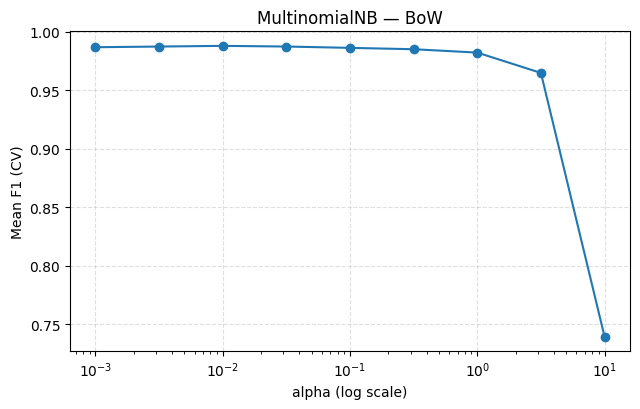

‚úÖ MultinomialNB (BoW) ‚Äî best alpha: 0.01


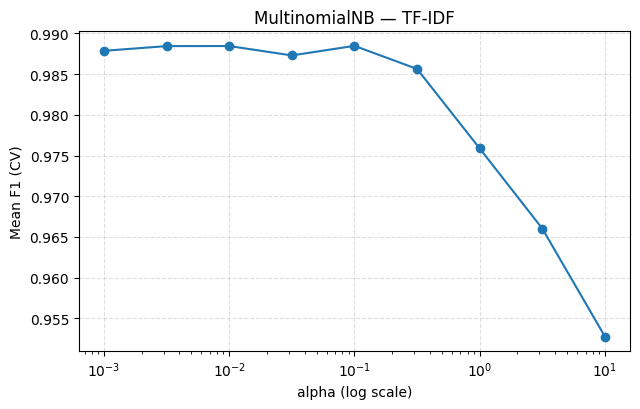

‚úÖ MultinomialNB (TF-IDF) ‚Äî best alpha: 0.1


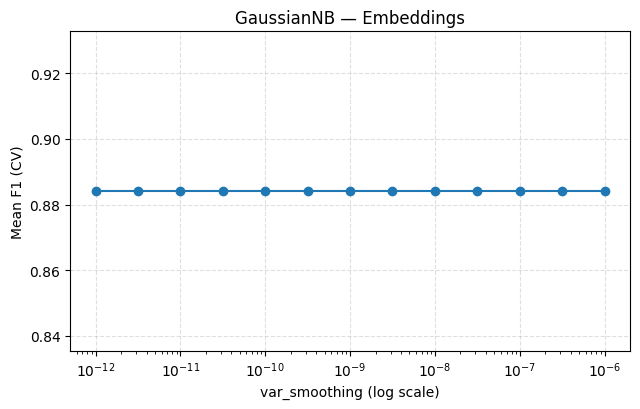

‚úÖ GaussianNB (Embeddings) ‚Äî best var_smoothing: 1.00e-12


In [70]:
# Naive Bayes
def _plot_semilog(xs, ys, xlabel, title):
    plt.figure(figsize=(6.5, 4.2))
    plt.semilogx(xs, ys, marker='o')
    plt.xlabel(xlabel); plt.ylabel("Mean F1 (CV)")
    plt.title(title); plt.grid(True, linestyle='--', alpha=.4)
    plt.tight_layout(); plt.show()

# BoW ‚Äî MultinomialNB
alphas = np.logspace(-3, 1, 9)
mnnb_bow_gs = GridSearchCV(MultinomialNB(), {'alpha': alphas}, scoring=f1_scorer, cv=cv, n_jobs=-1, refit=True)
mnnb_bow_gs.fit(X_train_bow_bal, y_train_bow_bal)
means_bow = [cross_val_score(MultinomialNB(alpha=a), X_train_bow_bal, y_train_bow_bal, cv=cv,
                             scoring=f1_scorer, n_jobs=-1).mean() for a in alphas]
_plot_semilog(alphas, means_bow, "alpha (log scale)", "MultinomialNB ‚Äî BoW")
best_alpha_bow = mnnb_bow_gs.best_params_['alpha']; print(f"‚úÖ MultinomialNB (BoW) ‚Äî best alpha: {best_alpha_bow:.3g}")
nb_bow = mnnb_bow_gs.best_estimator_; nb_bow_labels = nb_bow.predict(X_test_bow)

# TF-IDF ‚Äî MultinomialNB
mnnb_tfidf_gs = GridSearchCV(MultinomialNB(), {'alpha': alphas}, scoring=f1_scorer, cv=cv, n_jobs=-1, refit=True)
mnnb_tfidf_gs.fit(X_train_tfidf_bal, y_train_tfidf_bal)
means_tfidf = [cross_val_score(MultinomialNB(alpha=a), X_train_tfidf_bal, y_train_tfidf_bal, cv=cv,
                               scoring=f1_scorer, n_jobs=-1).mean() for a in alphas]
_plot_semilog(alphas, means_tfidf, "alpha (log scale)", "MultinomialNB ‚Äî TF-IDF")
best_alpha_tfidf = mnnb_tfidf_gs.best_params_['alpha']; print(f"‚úÖ MultinomialNB (TF-IDF) ‚Äî best alpha: {best_alpha_tfidf:.3g}")
nb_tfidf = mnnb_tfidf_gs.best_estimator_; nb_tfidf_labels = nb_tfidf.predict(X_test_tfidf)

# Embeddings ‚Äî GaussianNB
Xtr_emb = _to_dense(X_train_emb_bal); Xte_emb = _to_dense(X_test_embeddings)
vs_grid = np.logspace(-12, -6, 13)
gnb_gs = GridSearchCV(GaussianNB(), {'var_smoothing': vs_grid}, scoring=f1_scorer, cv=cv, n_jobs=-1, refit=True)
gnb_gs.fit(Xtr_emb, y_train_emb_bal)
means_vs = [cross_val_score(GaussianNB(var_smoothing=v), Xtr_emb, y_train_emb_bal, cv=cv,
                            scoring=f1_scorer, n_jobs=-1).mean() for v in vs_grid]
_plot_semilog(vs_grid, means_vs, "var_smoothing (log scale)", "GaussianNB ‚Äî Embeddings")
best_nb_vs = gnb_gs.best_params_['var_smoothing']; print(f"‚úÖ GaussianNB (Embeddings) ‚Äî best var_smoothing: {best_nb_vs:.2e}")
nb_emb = gnb_gs.best_estimator_; nb_emb_labels = nb_emb.predict(Xte_emb)

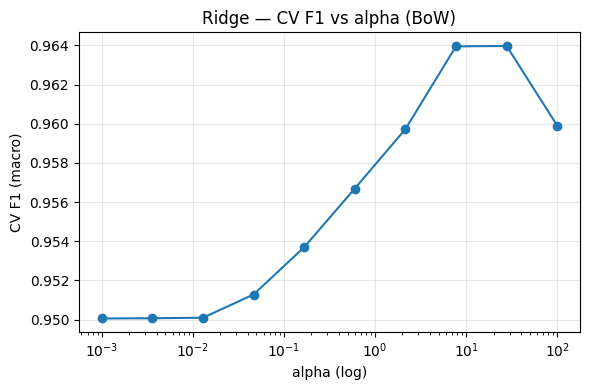

‚úÖ Ridge (BoW) ‚Äî best alpha: 27.83


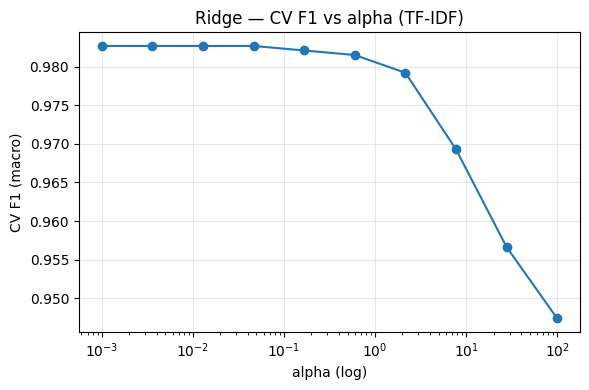

‚úÖ Ridge (TF-IDF) ‚Äî best alpha: 0.001


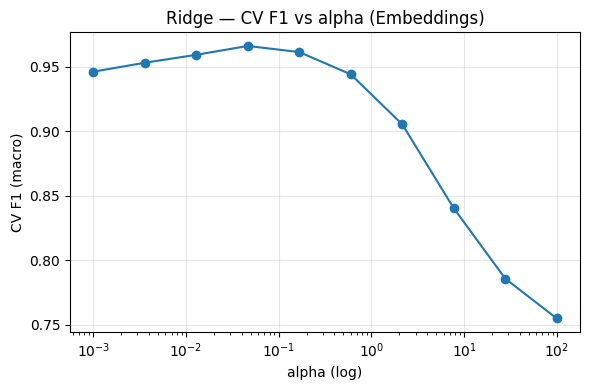

‚úÖ Ridge (Emb) ‚Äî best alpha: 0.04642


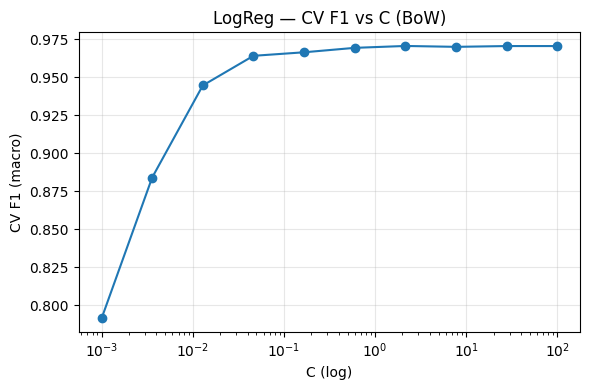

‚úÖ LogReg (BoW) ‚Äî best C: 2.154


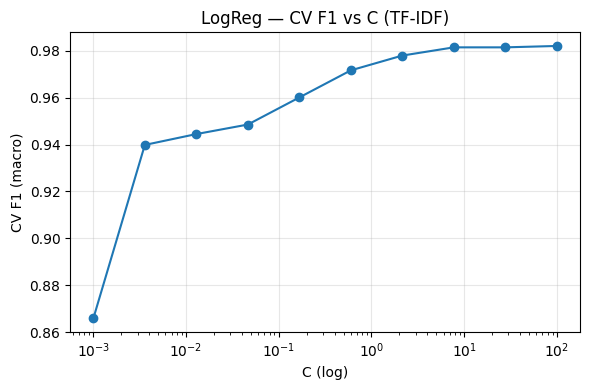

‚úÖ LogReg (TF-IDF) ‚Äî best C: 100


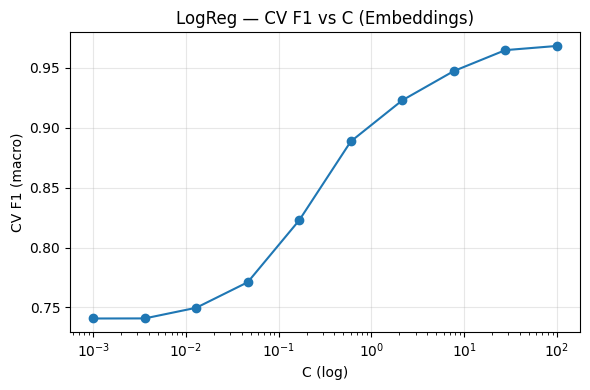

‚úÖ LogReg (Emb) ‚Äî best C: 100


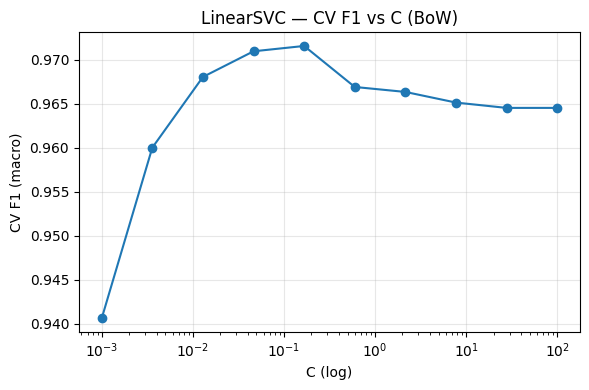

‚úÖ LinearSVC (BoW) ‚Äî best C: 0.1668


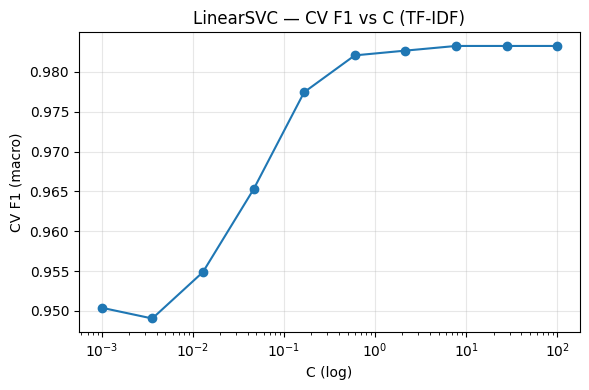

‚úÖ LinearSVC (TF-IDF) ‚Äî best C: 7.743


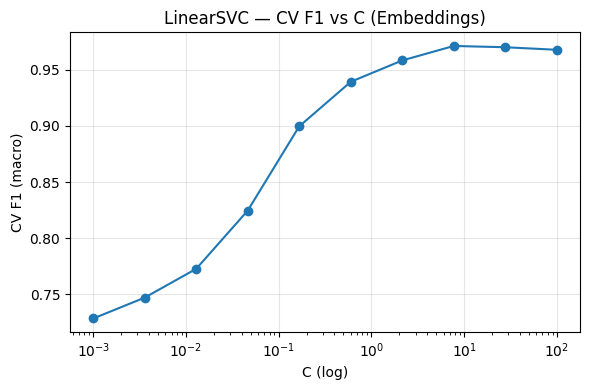

‚úÖ LinearSVC (Emb) ‚Äî best C: 7.743


In [71]:
# Ridge / Logistic Regression / LinearSVC
def tune_alpha_ridge(Xtr, ytr, title_suffix=""):
    alphas = np.logspace(-3, 2, 10); means = []
    for a in alphas:
        means.append(cross_val_score(RidgeClassifier(alpha=a, class_weight='balanced', random_state=SEED),
                                     Xtr, ytr, cv=cv, scoring=f1_scorer, n_jobs=-1).mean())
    plot_cv_curve(alphas, means, "alpha (log)", f"Ridge ‚Äî CV F1 vs alpha {title_suffix}", semilog=True)
    return float(alphas[int(np.argmax(means))])

best_ridge_alpha_bow = tune_alpha_ridge(X_train_bow_bal, y_train_bow_bal, "(BoW)")
ridge_bow = RidgeClassifier(alpha=best_ridge_alpha_bow, class_weight='balanced', random_state=SEED).fit(X_train_bow_bal, y_train_bow_bal)
ridge_bow_labels = ridge_bow.predict(X_test_bow)
print(f"‚úÖ Ridge (BoW) ‚Äî best alpha: {best_ridge_alpha_bow:.4g}")

best_ridge_alpha_tfidf = tune_alpha_ridge(X_train_tfidf_bal, y_train_tfidf_bal, "(TF-IDF)")
ridge_tfidf = RidgeClassifier(alpha=best_ridge_alpha_tfidf, class_weight='balanced', random_state=SEED).fit(X_train_tfidf_bal, y_train_tfidf_bal)
ridge_tfidf_labels = ridge_tfidf.predict(X_test_tfidf)
print(f"‚úÖ Ridge (TF-IDF) ‚Äî best alpha: {best_ridge_alpha_tfidf:.4g}")

best_ridge_alpha_emb = tune_alpha_ridge(X_train_emb_bal, y_train_emb_bal, "(Embeddings)")
ridge_emb = RidgeClassifier(alpha=best_ridge_alpha_emb, class_weight='balanced', random_state=SEED).fit(X_train_emb_bal, y_train_emb_bal)
ridge_emb_labels = ridge_emb.predict(X_test_embeddings)
print(f"‚úÖ Ridge (Emb) ‚Äî best alpha: {best_ridge_alpha_emb:.4g}")

def tune_C_logreg(Xtr, ytr, title_suffix=""):
    Cs = np.logspace(-3, 2, 10); means = []
    for C in Cs:
        clf = LogisticRegression(C=C, penalty='l2', solver='saga', max_iter=3000,
                                 class_weight='balanced', random_state=SEED, n_jobs=-1)
        means.append(cross_val_score(clf, Xtr, ytr, cv=cv, scoring=f1_scorer, n_jobs=-1).mean())
    plot_cv_curve(Cs, means, "C (log)", f"LogReg ‚Äî CV F1 vs C {title_suffix}", semilog=True)
    return float(Cs[int(np.argmax(means))])

best_logreg_C_bow = tune_C_logreg(X_train_bow_bal, y_train_bow_bal, "(BoW)")
log_bow = LogisticRegression(C=best_logreg_C_bow, penalty='l2', solver='saga', max_iter=3000,
                             class_weight='balanced', random_state=SEED, n_jobs=-1).fit(X_train_bow_bal, y_train_bow_bal)
log_bow_labels = log_bow.predict(X_test_bow)
print(f"‚úÖ LogReg (BoW) ‚Äî best C: {best_logreg_C_bow:.4g}")

best_logreg_C_tfidf = tune_C_logreg(X_train_tfidf_bal, y_train_tfidf_bal, "(TF-IDF)")
log_tfidf = LogisticRegression(C=best_logreg_C_tfidf, penalty='l2', solver='saga', max_iter=3000,
                               class_weight='balanced', random_state=SEED, n_jobs=-1).fit(X_train_tfidf_bal, y_train_tfidf_bal)
log_tfidf_labels = log_tfidf.predict(X_test_tfidf)
print(f"‚úÖ LogReg (TF-IDF) ‚Äî best C: {best_logreg_C_tfidf:.4g}")

best_logreg_C_emb = tune_C_logreg(X_train_emb_bal, y_train_emb_bal, "(Embeddings)")
log_emb = LogisticRegression(C=best_logreg_C_emb, penalty='l2', solver='saga', max_iter=3000,
                             class_weight='balanced', random_state=SEED, n_jobs=-1).fit(X_train_emb_bal, y_train_emb_bal)
log_emb_labels = log_emb.predict(X_test_embeddings)
print(f"‚úÖ LogReg (Emb) ‚Äî best C: {best_logreg_C_emb:.4g}")

def tune_C_linsvc(Xtr, ytr, title_suffix=""):
    Cs = np.logspace(-3, 2, 10); means = []
    for C in Cs:
        means.append(cross_val_score(LinearSVC(C=C, class_weight='balanced', random_state=SEED),
                                     Xtr, ytr, cv=cv, scoring=f1_scorer, n_jobs=-1).mean())
    plot_cv_curve(Cs, means, "C (log)", f"LinearSVC ‚Äî CV F1 vs C {title_suffix}", semilog=True)
    return float(Cs[int(np.argmax(means))])

best_lsvc_C_bow = tune_C_linsvc(X_train_bow_bal, y_train_bow_bal, "(BoW)")
svc_bow = LinearSVC(C=best_lsvc_C_bow, class_weight='balanced', random_state=SEED).fit(X_train_bow_bal, y_train_bow_bal)
svc_bow_labels = svc_bow.predict(X_test_bow)
print(f"‚úÖ LinearSVC (BoW) ‚Äî best C: {best_lsvc_C_bow:.4g}")

best_lsvc_C_tfidf = tune_C_linsvc(X_train_tfidf_bal, y_train_tfidf_bal, "(TF-IDF)")
svc_tfidf = LinearSVC(C=best_lsvc_C_tfidf, class_weight='balanced', random_state=SEED).fit(X_train_tfidf_bal, y_train_tfidf_bal)
svc_tfidf_labels = svc_tfidf.predict(X_test_tfidf)
print(f"‚úÖ LinearSVC (TF-IDF) ‚Äî best C: {best_lsvc_C_tfidf:.4g}")

best_lsvc_C_emb = tune_C_linsvc(X_train_emb_bal, y_train_emb_bal, "(Embeddings)")
svc_emb = LinearSVC(C=best_lsvc_C_emb, class_weight='balanced', random_state=SEED).fit(X_train_emb_bal, y_train_emb_bal)
svc_emb_labels = svc_emb.predict(X_test_embeddings)
print(f"‚úÖ LinearSVC (Emb) ‚Äî best C: {best_lsvc_C_emb:.4g}")

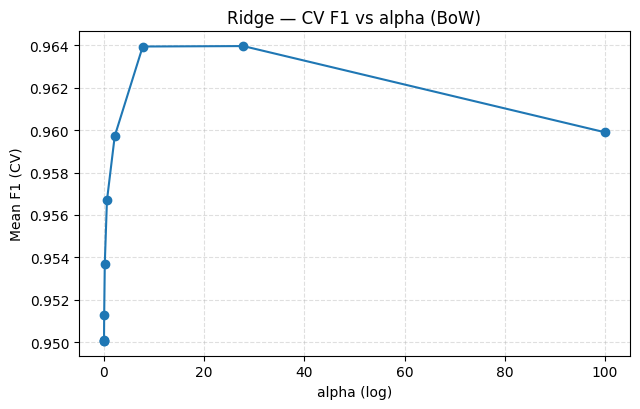

‚úÖ Ridge (BoW) ‚Äî best alpha: 27.83


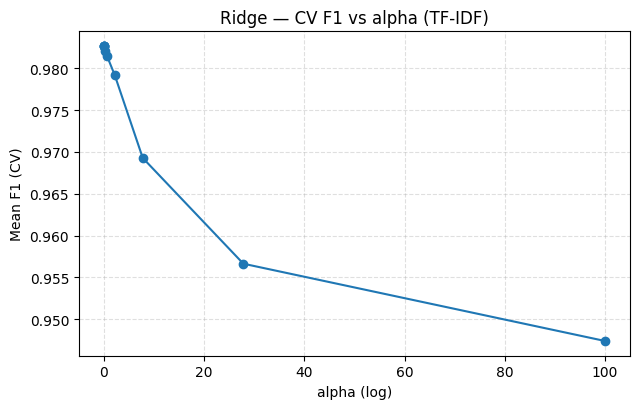

‚úÖ Ridge (TF-IDF) ‚Äî best alpha: 0.001


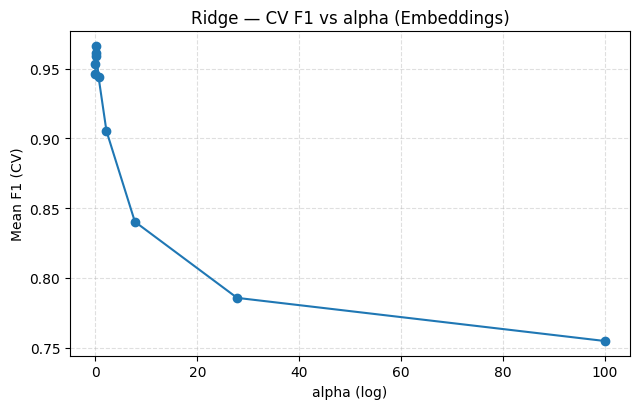

‚úÖ Ridge (Emb) ‚Äî best alpha: 0.04642


In [57]:
# # ===== 6) RidgeClassifier ‚Äî ch·ªçn alpha theo t·ª´ng bi·ªÉu di·ªÖn =====
# def tune_alpha_ridge(Xtr, ytr, title_suffix=""):
#     alphas = np.logspace(-3, 2, 10)  # 1e-3..1e2
#     means = []
#     for a in alphas:
#         clf = RidgeClassifier(alpha=a, class_weight='balanced', random_state=42)
#         s = cross_val_score(clf, Xtr, ytr, cv=cv, scoring=f1_scorer, n_jobs=-1)
#         means.append(s.mean())
#     plot_cv_curve(alphas, means, "alpha (log)", f"Ridge ‚Äî CV F1 vs alpha {title_suffix}")
#     return float(alphas[int(np.argmax(means))])

# # BoW
# best_ridge_alpha_bow = tune_alpha_ridge(X_train_bow_bal, y_train_bow_bal, "(BoW)")
# ridge_bow = RidgeClassifier(alpha=best_ridge_alpha_bow, class_weight='balanced', random_state=42)
# ridge_bow.fit(X_train_bow_bal, y_train_bow_bal)
# ridge_bow_labels = ridge_bow.predict(X_test_bow)
# print(f"‚úÖ Ridge (BoW) ‚Äî best alpha: {best_ridge_alpha_bow:.4g}")

# # TF-IDF
# best_ridge_alpha_tfidf = tune_alpha_ridge(X_train_tfidf_bal, y_train_tfidf_bal, "(TF-IDF)")
# ridge_tfidf = RidgeClassifier(alpha=best_ridge_alpha_tfidf, class_weight='balanced', random_state=42)
# ridge_tfidf.fit(X_train_tfidf_bal, y_train_tfidf_bal)
# ridge_tfidf_labels = ridge_tfidf.predict(X_test_tfidf)
# print(f"‚úÖ Ridge (TF-IDF) ‚Äî best alpha: {best_ridge_alpha_tfidf:.4g}")

# # Embeddings
# best_ridge_alpha_emb = tune_alpha_ridge(X_train_emb_bal, y_train_emb_bal, "(Embeddings)")
# ridge_emb = RidgeClassifier(alpha=best_ridge_alpha_emb, class_weight='balanced', random_state=42)
# ridge_emb.fit(X_train_emb_bal, y_train_emb_bal)
# ridge_emb_labels = ridge_emb.predict(X_test_embeddings)
# print(f"‚úÖ Ridge (Emb) ‚Äî best alpha: {best_ridge_alpha_emb:.4g}")


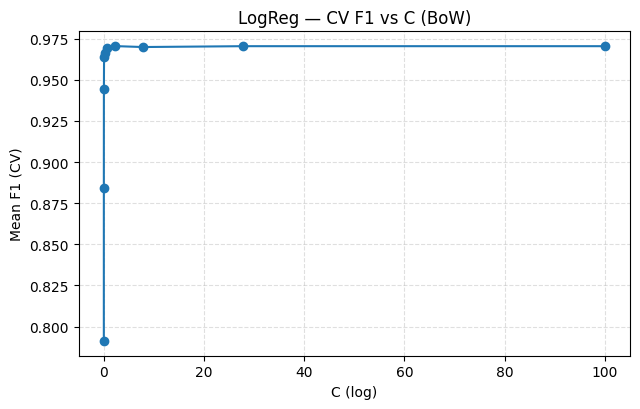

‚úÖ LogReg (BoW) ‚Äî best C: 2.154


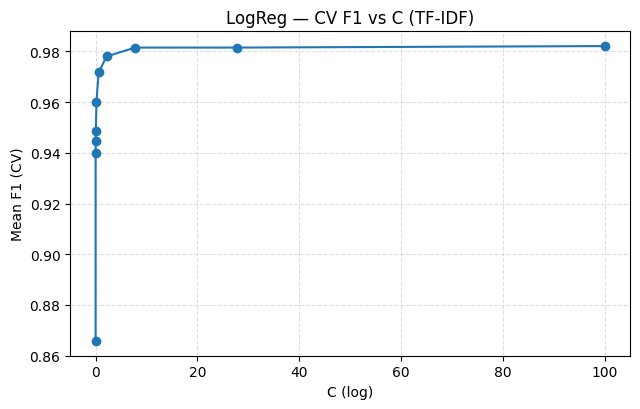

‚úÖ LogReg (TF-IDF) ‚Äî best C: 100


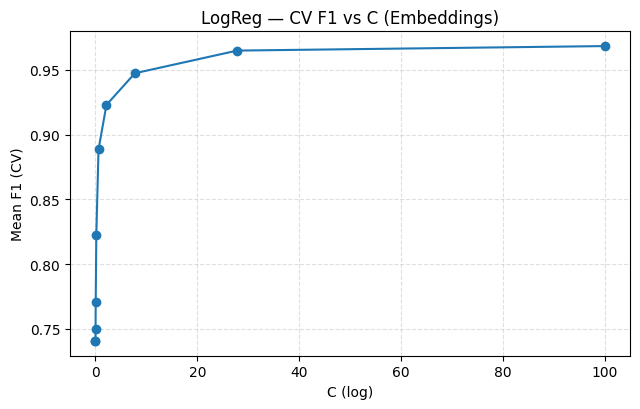

‚úÖ LogReg (Emb) ‚Äî best C: 100


In [58]:
# # ===== 7) Logistic Regression ‚Äî ch·ªçn C theo t·ª´ng bi·ªÉu di·ªÖn =====
# def tune_C_logreg(Xtr, ytr, title_suffix=""):
#     Cs = np.logspace(-3, 2, 10)
#     means = []
#     for C in Cs:
#         # 'saga' h·ªó tr·ª£ sparse + multiclass, ph√π h·ª£p cho BoW/TF-IDF; ·ªïn cho dense embeddings
#         clf = LogisticRegression(C=C, penalty='l2', solver='saga',
#                                  max_iter=3000, class_weight='balanced',
#                                  random_state=42, n_jobs=-1)
#         s = cross_val_score(clf, Xtr, ytr, cv=cv, scoring=f1_scorer, n_jobs=-1)
#         means.append(s.mean())
#     plot_cv_curve(Cs, means, "C (log)", f"LogReg ‚Äî CV F1 vs C {title_suffix}")
#     return float(Cs[int(np.argmax(means))])

# # BoW
# best_logreg_C_bow = tune_C_logreg(X_train_bow_bal, y_train_bow_bal, "(BoW)")
# log_bow = LogisticRegression(C=best_logreg_C_bow, penalty='l2', solver='saga',
#                              max_iter=3000, class_weight='balanced',
#                              random_state=42, n_jobs=-1)
# log_bow.fit(X_train_bow_bal, y_train_bow_bal)
# log_bow_labels = log_bow.predict(X_test_bow)
# print(f"‚úÖ LogReg (BoW) ‚Äî best C: {best_logreg_C_bow:.4g}")

# # TF-IDF
# best_logreg_C_tfidf = tune_C_logreg(X_train_tfidf_bal, y_train_tfidf_bal, "(TF-IDF)")
# log_tfidf = LogisticRegression(C=best_logreg_C_tfidf, penalty='l2', solver='saga',
#                                max_iter=3000, class_weight='balanced',
#                                random_state=42, n_jobs=-1)
# log_tfidf.fit(X_train_tfidf_bal, y_train_tfidf_bal)
# log_tfidf_labels = log_tfidf.predict(X_test_tfidf)
# print(f"‚úÖ LogReg (TF-IDF) ‚Äî best C: {best_logreg_C_tfidf:.4g}")

# # Embeddings
# best_logreg_C_emb = tune_C_logreg(X_train_emb_bal, y_train_emb_bal, "(Embeddings)")
# log_emb = LogisticRegression(C=best_logreg_C_emb, penalty='l2', solver='saga',
#                              max_iter=3000, class_weight='balanced',
#                              random_state=42, n_jobs=-1)
# log_emb.fit(X_train_emb_bal, y_train_emb_bal)
# log_emb_labels = log_emb.predict(X_test_embeddings)
# print(f"‚úÖ LogReg (Emb) ‚Äî best C: {best_logreg_C_emb:.4g}")


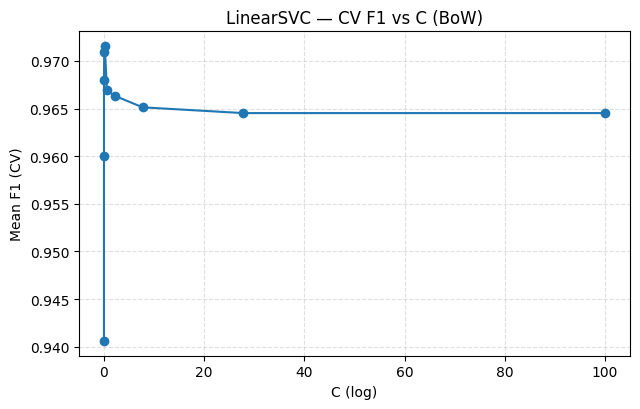

‚úÖ LinearSVC (BoW) ‚Äî best C: 0.1668


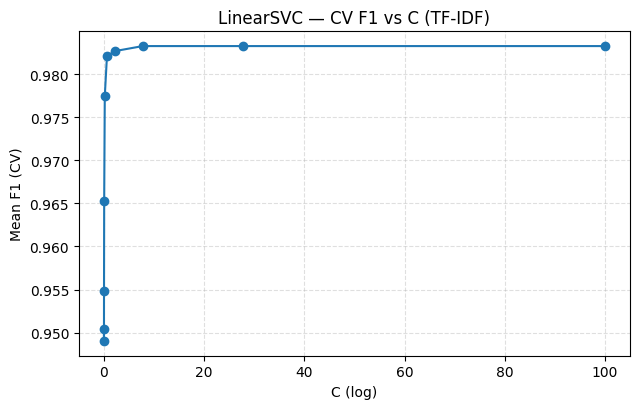

‚úÖ LinearSVC (TF-IDF) ‚Äî best C: 7.743


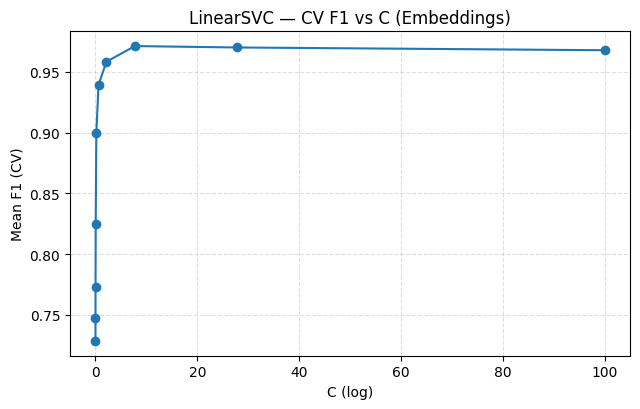

‚úÖ LinearSVC (Emb) ‚Äî best C: 7.743


In [39]:
# # ===== 8) LinearSVC ‚Äî ch·ªçn C theo t·ª´ng bi·ªÉu di·ªÖn =====
# def tune_C_linsvc(Xtr, ytr, title_suffix=""):
#     Cs = np.logspace(-3, 2, 10)
#     means = []
#     for C in Cs:
#         clf = LinearSVC(C=C, class_weight='balanced', random_state=42)
#         s = cross_val_score(clf, Xtr, ytr, cv=cv, scoring=f1_scorer, n_jobs=-1)
#         means.append(s.mean())
#     plot_cv_curve(Cs, means, "C (log)", f"LinearSVC ‚Äî CV F1 vs C {title_suffix}")
#     return float(Cs[int(np.argmax(means))])

# # BoW
# best_lsvc_C_bow = tune_C_linsvc(X_train_bow_bal, y_train_bow_bal, "(BoW)")
# svc_bow = LinearSVC(C=best_lsvc_C_bow, class_weight='balanced', random_state=42)
# svc_bow.fit(X_train_bow_bal, y_train_bow_bal)
# svc_bow_labels = svc_bow.predict(X_test_bow)
# print(f"‚úÖ LinearSVC (BoW) ‚Äî best C: {best_lsvc_C_bow:.4g}")

# # TF-IDF
# best_lsvc_C_tfidf = tune_C_linsvc(X_train_tfidf_bal, y_train_tfidf_bal, "(TF-IDF)")
# svc_tfidf = LinearSVC(C=best_lsvc_C_tfidf, class_weight='balanced', random_state=42)
# svc_tfidf.fit(X_train_tfidf_bal, y_train_tfidf_bal)
# svc_tfidf_labels = svc_tfidf.predict(X_test_tfidf)
# print(f"‚úÖ LinearSVC (TF-IDF) ‚Äî best C: {best_lsvc_C_tfidf:.4g}")

# # Embeddings
# best_lsvc_C_emb = tune_C_linsvc(X_train_emb_bal, y_train_emb_bal, "(Embeddings)")
# svc_emb = LinearSVC(C=best_lsvc_C_emb, class_weight='balanced', random_state=42)
# svc_emb.fit(X_train_emb_bal, y_train_emb_bal)
# svc_emb_labels = svc_emb.predict(X_test_embeddings)
# print(f"‚úÖ LinearSVC (Emb) ‚Äî best C: {best_lsvc_C_emb:.4g}")


Model     Feature               BestParam  BestCV_F1
0   GaussianNB         BoW  var_smoothing=1.00e-12   0.978673
1   GaussianNB  Embeddings  var_smoothing=1.00e-12   0.884064
2   GaussianNB      TF-IDF  var_smoothing=1.00e-12   0.978078
3    LinearSVC         BoW                C=0.1668   0.971558
4    LinearSVC  Embeddings                 C=7.743   0.971265
5    LinearSVC      TF-IDF                 C=7.743   0.983256
6       LogReg         BoW                 C=2.154   0.970456
7       LogReg  Embeddings                   C=100   0.968384
8       LogReg      TF-IDF                   C=100   0.982085
9        Ridge         BoW             alpha=27.83   0.963967
10       Ridge  Embeddings           alpha=0.04642   0.966128
11       Ridge      TF-IDF             alpha=0.001   0.982667

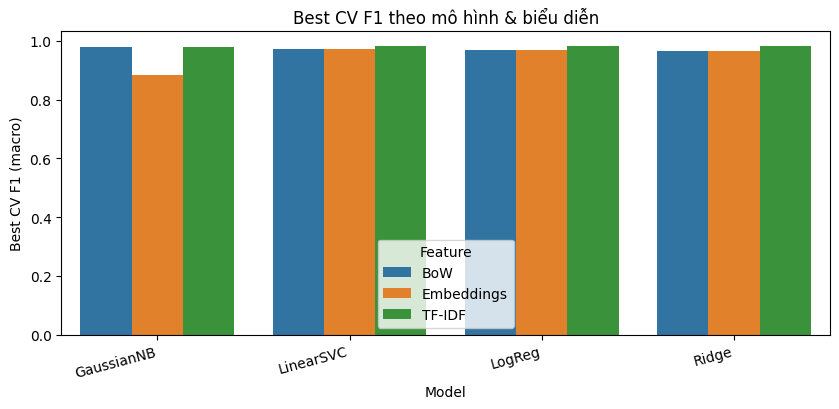

üèÜ Best among linear family (CV): LinearSVC | Feature=TF-IDF | C=7.743 | F1=0.9833


In [72]:
# ====== 9) T·ªïng h·ª£p k·∫øt qu·∫£ & m√¥ h√¨nh t·ªët nh·∫•t m·ªói nh√≥m ======
def cv_f1(est, X, y): return cross_val_score(est, X, y, cv=cv, scoring=f1_scorer, n_jobs=-1).mean()

rows = []
def add_row(model_name, feature, param_str, estimator, Xtr, ytr):
    if estimator is None or Xtr is None: return
    rows.append({"Model": model_name, "Feature": feature, "BestParam": param_str,
                 "BestCV_F1": cv_f1(estimator, Xtr, ytr)})

# KNN (n·∫øu c√≥ best_k_* trong globals)
def _knn_row(best_k, feat_name, Xtr, ytr):
    if best_k is None or Xtr is None: return
    add_row("KNN", feat_name, f"k={best_k}", KNeighborsClassifier(n_neighbors=int(best_k)), Xtr, ytr)

_knn_row(globals().get("best_k_knn_bow"),   "BoW",        globals().get("X_train_bow_bal"),   globals().get("y_train_bow_bal"))
_knn_row(globals().get("best_k_knn_tfidf"), "TF-IDF",     globals().get("X_train_tfidf_bal"), globals().get("y_train_tfidf_bal"))
_knn_row(globals().get("best_k_knn_emb"),   "Embeddings", globals().get("X_train_emb_bal"),   globals().get("y_train_emb_bal"))

# GaussianNB
def _nb_row(best_vs, feat_name, Xtr, ytr):
    if best_vs is None or Xtr is None: return
    Xtr2 = _to_dense(Xtr)
    add_row("GaussianNB", feat_name, f"var_smoothing={best_vs:.2e}", GaussianNB(var_smoothing=float(best_vs)), Xtr2, ytr)

_nb_row(globals().get("best_nb_vs_bow", best_nb_vs if 'best_nb_vs' in globals() else None), "BoW",        globals().get("X_train_bow_bal"),   globals().get("y_train_bow_bal"))
_nb_row(globals().get("best_nb_vs_tfidf", globals().get("best_nb_vs", None)),               "TF-IDF",     globals().get("X_train_tfidf_bal"), globals().get("y_train_tfidf_bal"))
_nb_row(globals().get("best_nb_vs_emb", globals().get("best_nb_vs", None)),                 "Embeddings", globals().get("X_train_emb_bal"),   globals().get("y_train_emb_bal"))

# Ridge / LogReg / LinearSVC
add_row("Ridge", "BoW",        f"alpha={best_ridge_alpha_bow:.4g}",   RidgeClassifier(alpha=float(best_ridge_alpha_bow), class_weight='balanced', random_state=SEED), X_train_bow_bal,   y_train_bow_bal)
add_row("Ridge", "TF-IDF",     f"alpha={best_ridge_alpha_tfidf:.4g}", RidgeClassifier(alpha=float(best_ridge_alpha_tfidf), class_weight='balanced', random_state=SEED), X_train_tfidf_bal, y_train_tfidf_bal)
add_row("Ridge", "Embeddings", f"alpha={best_ridge_alpha_emb:.4g}",   RidgeClassifier(alpha=float(best_ridge_alpha_emb), class_weight='balanced', random_state=SEED), X_train_emb_bal,   y_train_emb_bal)

add_row("LogReg", "BoW",        f"C={best_logreg_C_bow:.4g}",   LogisticRegression(C=float(best_logreg_C_bow), penalty='l2', solver='saga', max_iter=3000, class_weight='balanced', random_state=SEED, n_jobs=-1), X_train_bow_bal,   y_train_bow_bal)
add_row("LogReg", "TF-IDF",     f"C={best_logreg_C_tfidf:.4g}", LogisticRegression(C=float(best_logreg_C_tfidf), penalty='l2', solver='saga', max_iter=3000, class_weight='balanced', random_state=SEED, n_jobs=-1), X_train_tfidf_bal, y_train_tfidf_bal)
add_row("LogReg", "Embeddings", f"C={best_logreg_C_emb:.4g}",   LogisticRegression(C=float(best_logreg_C_emb), penalty='l2', solver='saga', max_iter=3000, class_weight='balanced', random_state=SEED, n_jobs=-1), X_train_emb_bal,   y_train_emb_bal)

add_row("LinearSVC", "BoW",        f"C={best_lsvc_C_bow:.4g}",   LinearSVC(C=float(best_lsvc_C_bow), class_weight='balanced', random_state=SEED), X_train_bow_bal,   y_train_bow_bal)
add_row("LinearSVC", "TF-IDF",     f"C={best_lsvc_C_tfidf:.4g}", LinearSVC(C=float(best_lsvc_C_tfidf), class_weight='balanced', random_state=SEED), X_train_tfidf_bal, y_train_tfidf_bal)
add_row("LinearSVC", "Embeddings", f"C={best_lsvc_C_emb:.4g}",   LinearSVC(C=float(best_lsvc_C_emb), class_weight='balanced', random_state=SEED), X_train_emb_bal,   y_train_emb_bal)

summary = pd.DataFrame(rows).sort_values(by=["Model","Feature"]).reset_index(drop=True)
display(summary)

plt.figure(figsize=(8.5, 4.2))
bar_df = summary.dropna(subset=["BestCV_F1"]).copy()
sns.barplot(data=bar_df, x="Model", y="BestCV_F1", hue="Feature")
plt.xticks(rotation=15, ha='right'); plt.ylabel('Best CV F1 (macro)')
plt.title('Best CV F1 theo m√¥ h√¨nh & bi·ªÉu di·ªÖn'); plt.tight_layout(); plt.show()

linear_df = bar_df[bar_df["Model"].isin(["Ridge","LogReg","LinearSVC"])].copy()
if not linear_df.empty:
    best_row = linear_df.iloc[linear_df["BestCV_F1"].argmax()]
    print(f"üèÜ Best among linear family (CV): {best_row['Model']} | Feature={best_row['Feature']} | {best_row['BestParam']} | F1={best_row['BestCV_F1']:.4f}")
else:
    print("‚ö†Ô∏è Kh√¥ng c√≥ k·∫øt qu·∫£ nh√≥m linear ƒë·ªÉ t·ªïng h·ª£p.")

In [73]:
# ===== 3) B·∫£ng t√≥m t·∫Øt nhanh =====
rows = []
rows += [_summarize("KNN ‚Äî BoW",         y_test, knn_bow_labels)]
rows += [_summarize("KNN ‚Äî TF-IDF",      y_test, knn_tfidf_labels)]
rows += [_summarize("KNN ‚Äî Embeddings",  y_test, knn_emb_labels)]

rows += [_summarize("Decision Tree ‚Äî BoW",        y_test, dt_bow_labels)]
rows += [_summarize("Decision Tree ‚Äî TF-IDF",     y_test, dt_tfidf_labels)]
rows += [_summarize("Decision Tree ‚Äî Embeddings", y_test, dt_emb_labels)]

rows += [_summarize("Naive Bayes ‚Äî BoW",         y_test, nb_bow_labels)]
rows += [_summarize("Naive Bayes ‚Äî TF-IDF",      y_test, nb_tfidf_labels)]
rows += [_summarize("Naive Bayes ‚Äî Embeddings",  y_test, nb_emb_labels)]

rows += [_summarize("LinearSVC ‚Äî BoW",        y_test, svc_bow_labels)]
rows += [_summarize("LinearSVC ‚Äî TF-IDF",     y_test, svc_tfidf_labels)]
rows += [_summarize("LinearSVC ‚Äî Embeddings", y_test, svc_emb_labels)]

rows += [_summarize("LogReg ‚Äî BoW",        y_test, log_bow_labels)]
rows += [_summarize("LogReg ‚Äî TF-IDF",     y_test, log_tfidf_labels)]
rows += [_summarize("LogReg ‚Äî Embeddings", y_test, log_emb_labels)]

rows += [_summarize("Ridge ‚Äî BoW",        y_test, ridge_bow_labels)]
rows += [_summarize("Ridge ‚Äî TF-IDF",     y_test, ridge_tfidf_labels)]
rows += [_summarize("Ridge ‚Äî Embeddings", y_test, ridge_emb_labels)]

results_df_all = pd.DataFrame(rows).sort_values(["f1_macro","accuracy"], ascending=False).reset_index(drop=True)
print("\nüèÅ T·ªïng h·ª£p (top 10 theo F1-macro):")
display(results_df_all.head(10))
best = results_df_all.iloc[0]
print(f"üèÜ Best: {best['model_feature']} | Acc={best['accuracy']:.4f} | F1-macro={best['f1_macro']:.4f}")


üèÅ T·ªïng h·ª£p (top 10 theo F1-macro):


model_feature  accuracy  f1_macro  f1_weighted
0        Ridge ‚Äî Embeddings     0.920  0.824190     0.915303
1    LinearSVC ‚Äî Embeddings     0.915  0.785925     0.909964
2       LogReg ‚Äî Embeddings     0.900  0.726147     0.891314
3          KNN ‚Äî Embeddings     0.895  0.712250     0.880666
4  Naive Bayes ‚Äî Embeddings     0.885  0.707016     0.873674
5         Naive Bayes ‚Äî BoW     0.905  0.670459     0.881452
6      Naive Bayes ‚Äî TF-IDF     0.900  0.669934     0.879855
7            Ridge ‚Äî TF-IDF     0.895  0.665512     0.875052
8        LinearSVC ‚Äî TF-IDF     0.895  0.655015     0.873433
9           LogReg ‚Äî TF-IDF     0.895  0.654272     0.873710

üèÜ Best: Ridge ‚Äî Embeddings | Acc=0.9200 | F1-macro=0.8242


# **6. T·ªïng h·ª£p k·∫øt qu·∫£ + V·∫Ω t·∫•t c·∫£ m√¥ h√¨nh**

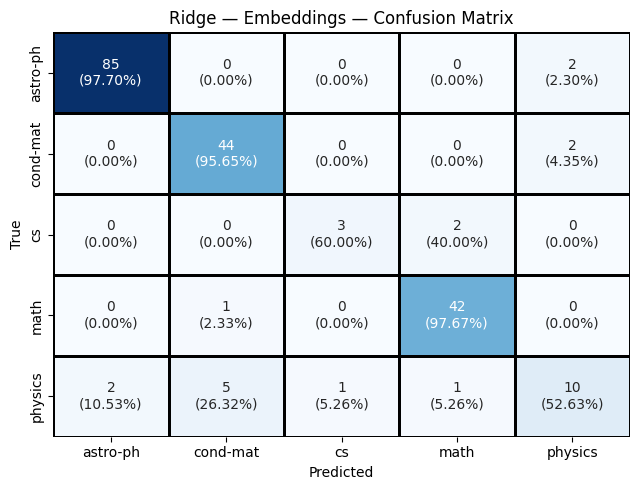

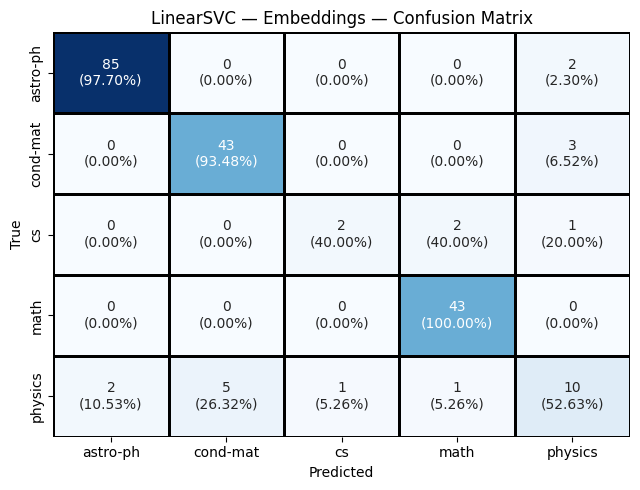

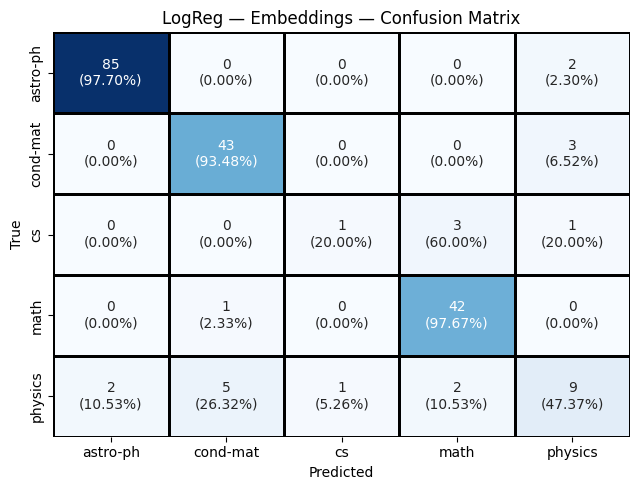

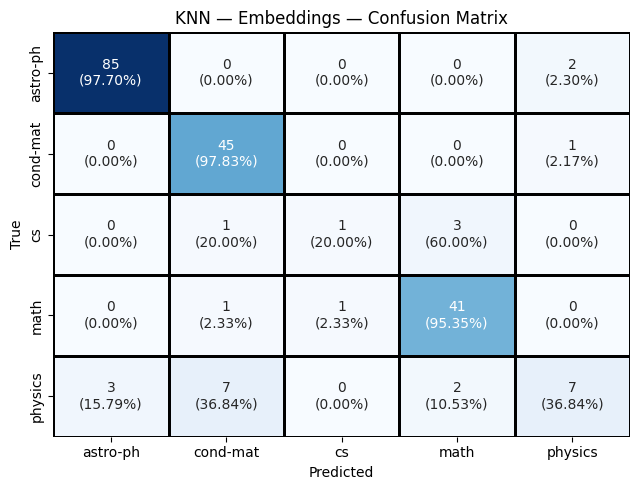

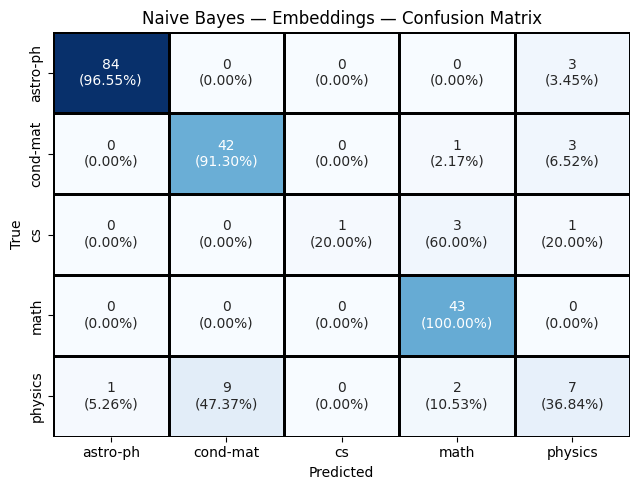

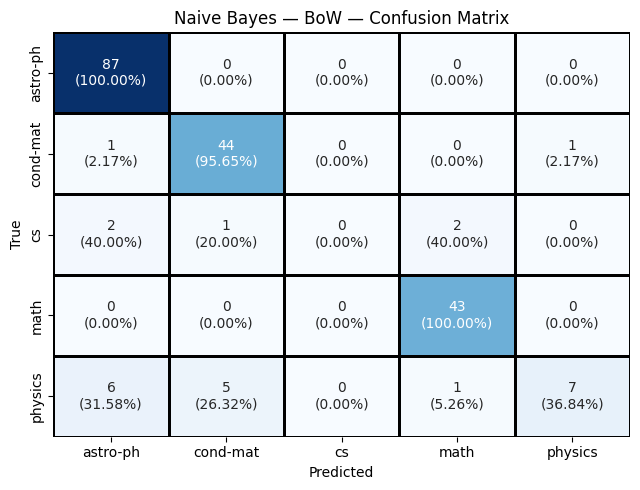

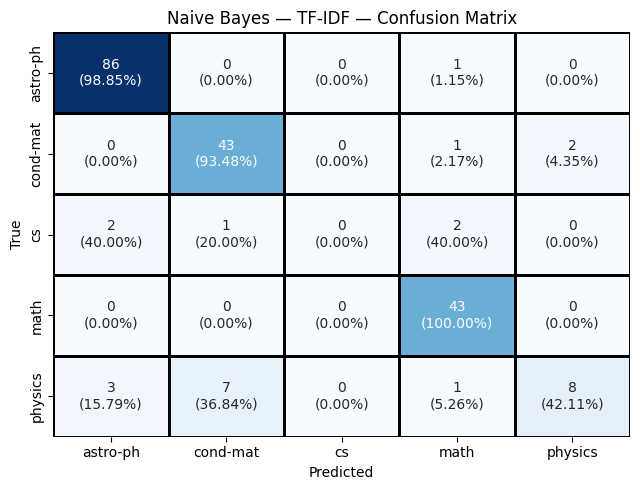

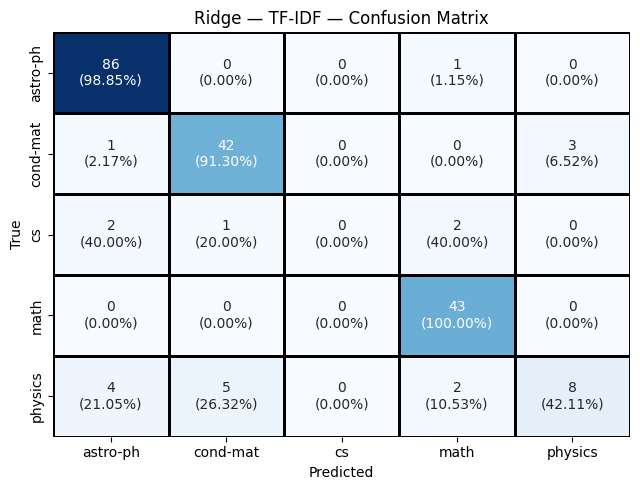

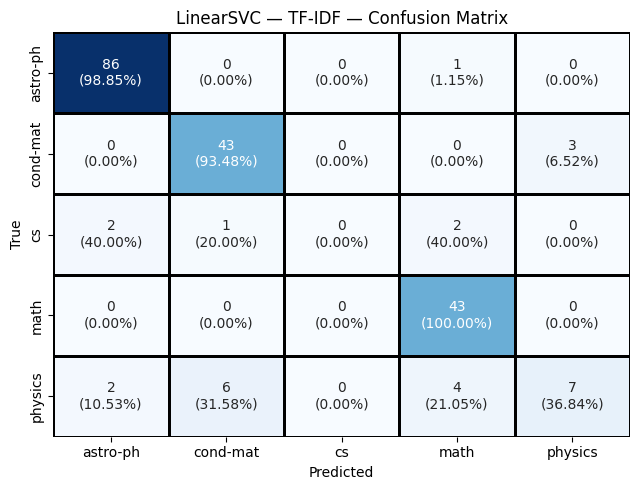

üèÜ Top: Ridge ‚Äî Embeddings | Acc=0.9200 | F1-macro=0.8242
üìÅ Confusion Matrix ƒë√£ l∆∞u:
 - pdf/Figures/all_models (t·∫•t c·∫£ m√¥ h√¨nh)
 - pdf/Figures/balanced (so s√°nh c√¢n b·∫±ng)
üíæ ƒê√£ l∆∞u: all_models_metrics.csv


In [74]:
def _cm_annot(cm: np.ndarray) -> np.ndarray:
    cmn = cm.astype(float) / np.clip(cm.sum(axis=1, keepdims=True), 1, None)
    ann = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ann[i, j] = f"{cm[i, j]}\n({cmn[i, j]:.2%})"
    return ann

def _save_cm(y_true, y_pred, title, save_dir, fname_stub, show=True):
    cm = confusion_matrix(y_true, y_pred, labels=labels_idx)
    ann = _cm_annot(cm)
    plt.figure(figsize=(6.5, 5))
    sns.heatmap(cm, annot=ann, fmt="", cmap="Blues",
                xticklabels=sorted_labels, yticklabels=sorted_labels,
                cbar=False, linewidths=1, linecolor='black')
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.tight_layout()
    fn = re.sub(r"[^a-zA-Z0-9\-_.]+", "_", fname_stub) + "_cm.pdf"
    path = os.path.join(PATHS.all_models, fn)
    plt.savefig(path, bbox_inches="tight")
    if show: plt.show()
    else:    plt.close()

SHOW_TOP_N = 9
pred_map = {
    "KNN ‚Äî BoW": knn_bow_labels, "KNN ‚Äî TF-IDF": knn_tfidf_labels, "KNN ‚Äî Embeddings": knn_emb_labels,
    "Decision Tree ‚Äî BoW": dt_bow_labels, "Decision Tree ‚Äî TF-IDF": dt_tfidf_labels, "Decision Tree ‚Äî Embeddings": dt_emb_labels,
    "Naive Bayes ‚Äî BoW": nb_bow_labels, "Naive Bayes ‚Äî TF-IDF": nb_tfidf_labels, "Naive Bayes ‚Äî Embeddings": nb_emb_labels,
    "LinearSVC ‚Äî BoW": svc_bow_labels, "LinearSVC ‚Äî TF-IDF": svc_tfidf_labels, "LinearSVC ‚Äî Embeddings": svc_emb_labels,
    "LogReg ‚Äî BoW": log_bow_labels, "LogReg ‚Äî TF-IDF": log_tfidf_labels, "LogReg ‚Äî Embeddings": log_emb_labels,
    "Ridge ‚Äî BoW": ridge_bow_labels, "Ridge ‚Äî TF-IDF": ridge_tfidf_labels, "Ridge ‚Äî Embeddings": ridge_emb_labels,
}
order_names = results_df_all["model_feature"].tolist()
for i, name in enumerate(order_names):
    _save_cm(y_test, pred_map[name], title=f"{name} ‚Äî Confusion Matrix",
             save_dir=PATHS.all_models, fname_stub=name, show=(i < SHOW_TOP_N))

# (Tu·ª≥ ch·ªçn) So s√°nh tr∆∞·ªõc/sau c√¢n b·∫±ng n·∫øu c√≥ bi·∫øn *_pre
def plot_confusion_single(y_true, y_pred, class_names=None, title="", save_path=None):
    class_names = class_names or sorted_labels
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    ann = _cm_annot(cm)
    plt.figure(figsize=(6.5, 5))
    sns.heatmap(cm, annot=ann, fmt="", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, linewidths=1, linecolor='black')
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.tight_layout()
    if save_path: plt.savefig(save_path, bbox_inches="tight")
    plt.show()

def compare_confusions(y_true, y_pred_pre, y_pred_post, class_names=None,
                       title_pre="Tr∆∞·ªõc c√¢n b·∫±ng", title_post="Sau c√¢n b·∫±ng", save_path=None):
    class_names = class_names or sorted_labels
    labels = range(len(class_names))
    cm_pre  = confusion_matrix(y_true, y_pred_pre,  labels=labels)
    cm_post = confusion_matrix(y_true, y_pred_post, labels=labels)
    ann_pre, ann_post = _cm_annot(cm_pre), _cm_annot(cm_post)
    fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharex=True, sharey=True)
    sns.heatmap(cm_pre,  annot=ann_pre,  fmt="", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, linewidths=1, linecolor='black', ax=axes[0])
    axes[0].set_title(title_pre); axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")
    sns.heatmap(cm_post, annot=ann_post, fmt="", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, linewidths=1, linecolor='black', ax=axes[1])
    axes[1].set_title(title_post); axes[1].set_xlabel("Predicted")
    plt.tight_layout()
    if save_path: plt.savefig(save_path, bbox_inches="tight")
    plt.show()

# V√≠ d·ª• d√πng (n·∫øu c√≥ *_pre trong globals):
# if 'knn_bow_labels_pre' in globals():
#     compare_confusions(y_test, knn_bow_labels_pre, knn_bow_labels,
#                        sorted_labels, "KNN-BoW (tr∆∞·ªõc c√¢n b·∫±ng)", "KNN-BoW (sau c√¢n b·∫±ng)",
#                        save_path=os.path.join(PATHS.balanced, "knn_bow_compare.pdf"))

# ==== L∆∞u CSV & k·∫øt lu·∫≠n nhanh ====
csv_path = "all_models_metrics.csv"
results_df_all.to_csv(csv_path, index=False)
lead = results_df_all.iloc[0]
print(f"üèÜ Top: {lead['model_feature']} | Acc={lead['accuracy']:.4f} | F1-macro={lead['f1_macro']:.4f}")
print(f"üìÅ Confusion Matrix ƒë√£ l∆∞u:\n - {PATHS.all_models} (t·∫•t c·∫£ m√¥ h√¨nh)\n - {PATHS.balanced} (so s√°nh c√¢n b·∫±ng)")
print(f"üíæ ƒê√£ l∆∞u: {csv_path}")

üèÅ B·∫£ng t·ªïng h·ª£p (top 12 theo F1-macro):


model_feature         algo        repr  accuracy  f1_macro  \
0         Ridge ‚Äî Embeddings        Ridge  Embeddings     0.920  0.824190   
1     LinearSVC ‚Äî Embeddings    LinearSVC  Embeddings     0.915  0.785925   
2        LogReg ‚Äî Embeddings       LogReg  Embeddings     0.900  0.726147   
3           KNN ‚Äî Embeddings          KNN  Embeddings     0.895  0.712250   
4   Naive Bayes ‚Äî Embeddings  Naive Bayes  Embeddings     0.885  0.707016   
5          Naive Bayes ‚Äî BoW  Naive Bayes         BoW     0.905  0.670459   
6       Naive Bayes ‚Äî TF-IDF  Naive Bayes      TF-IDF     0.900  0.669934   
7             Ridge ‚Äî TF-IDF        Ridge      TF-IDF     0.895  0.665512   
8         LinearSVC ‚Äî TF-IDF    LinearSVC      TF-IDF     0.895  0.655015   
9            LogReg ‚Äî TF-IDF       LogReg      TF-IDF     0.895  0.654272   
10               Ridge ‚Äî BoW        Ridge         BoW     0.840  0.610642   
11              KNN ‚Äî TF-IDF          KNN      TF-IDF     0.815  0.607776   

    f1_weighted  
0      0.915303  
1      0.909964  
2      0.891314  
3      0.880666  
4      0.873674  
5      0.881452  
6      0.879855  
7      0.875052  
8      0.873433  
9      0.873710  
10     0.826041  
11     0.811029

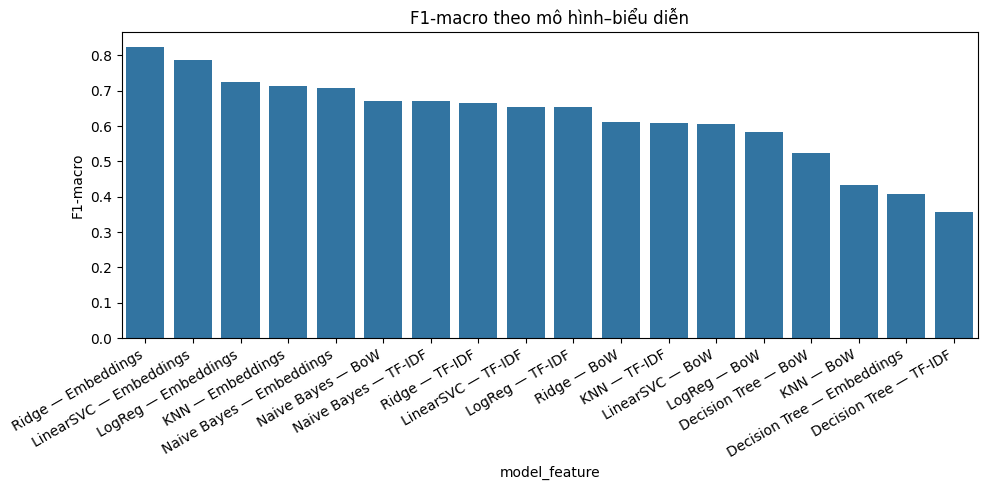

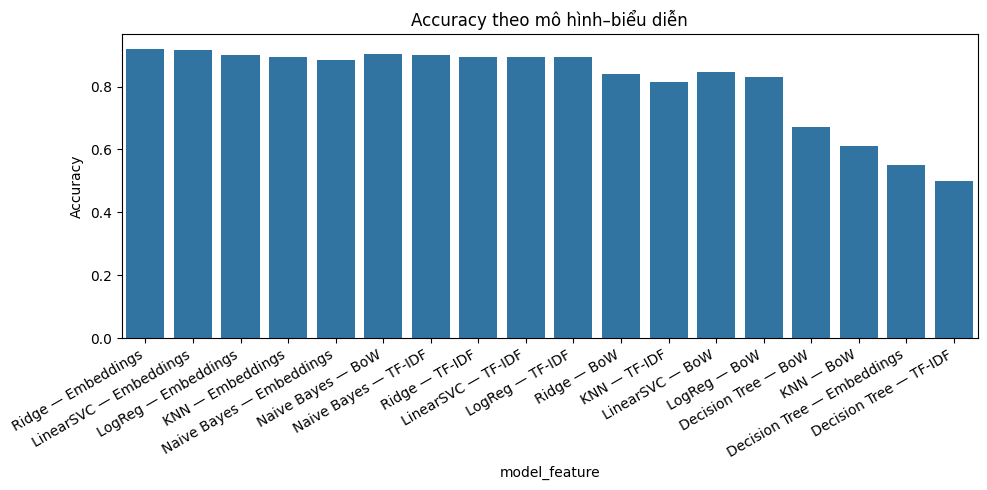

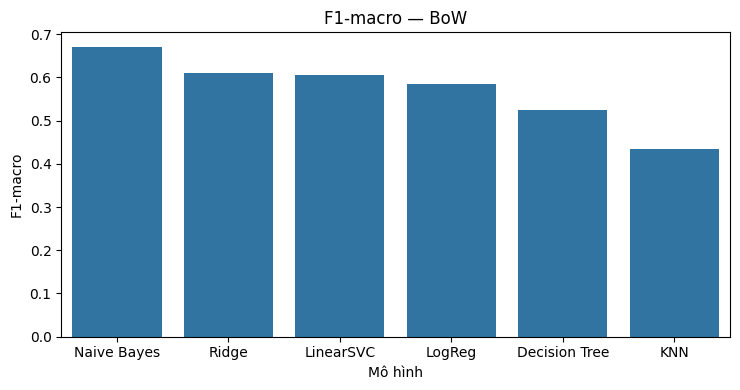

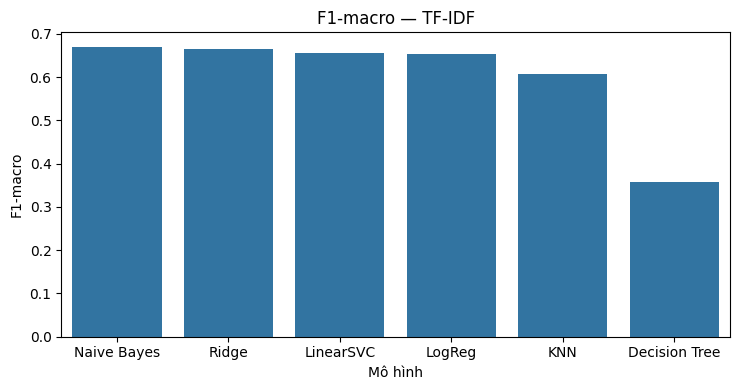

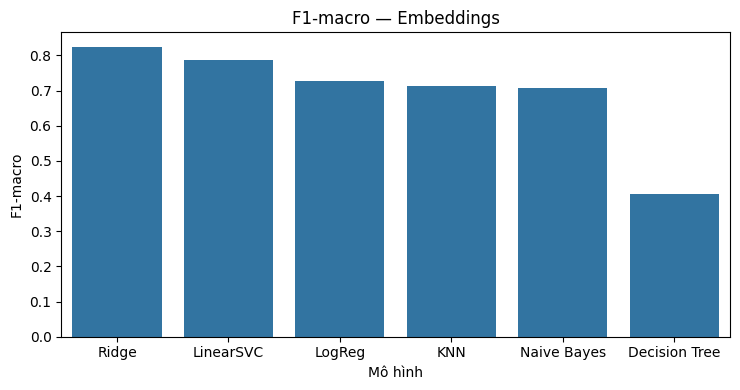

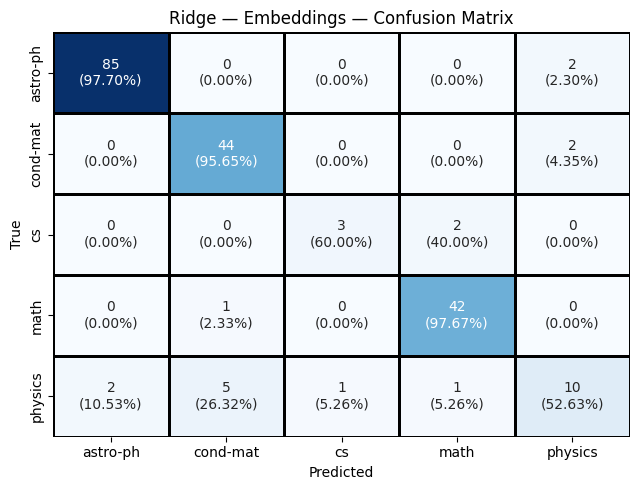

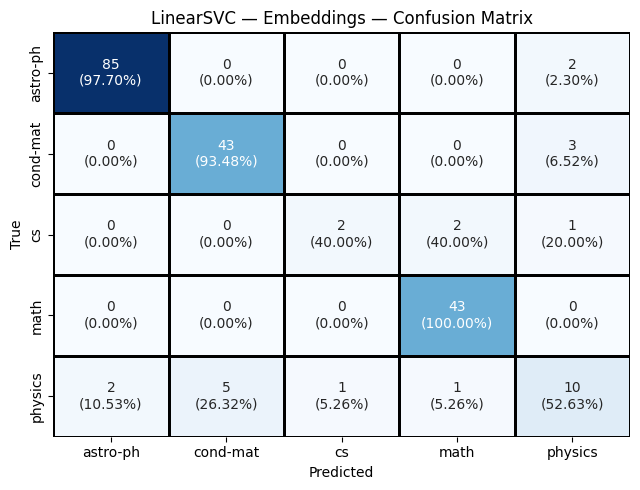

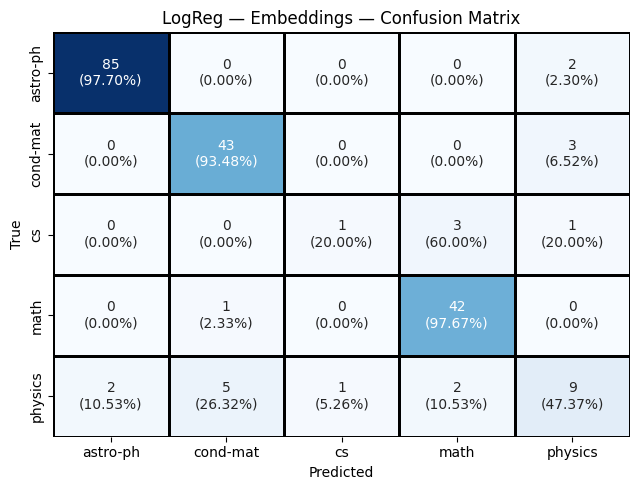

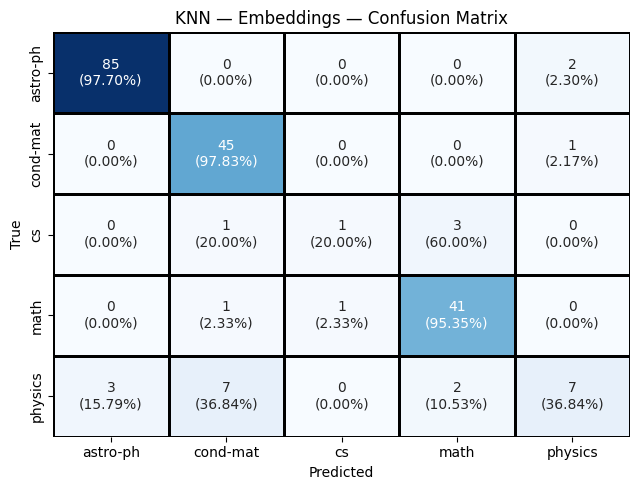

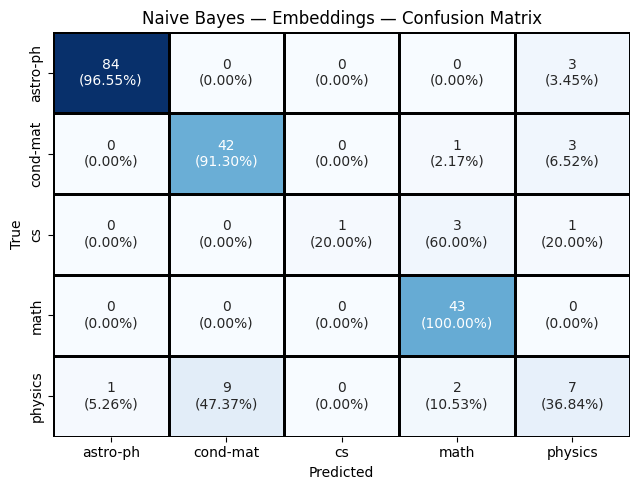

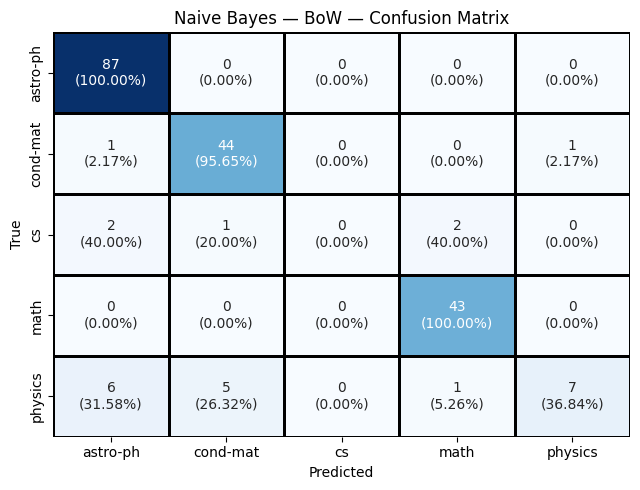

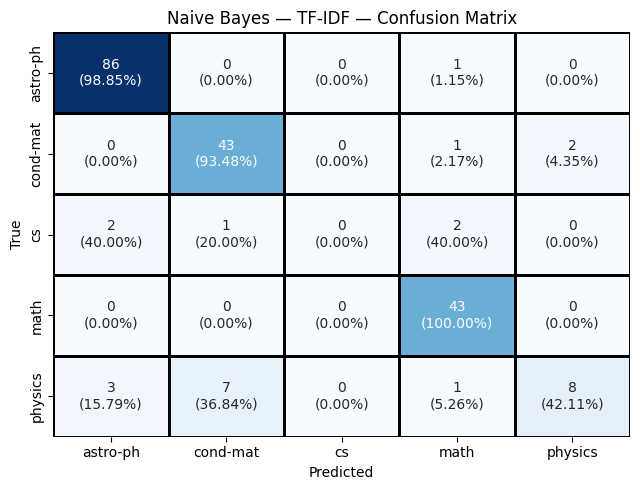

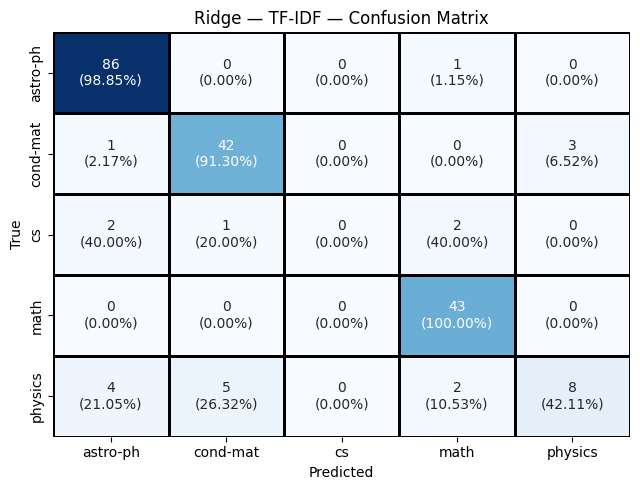

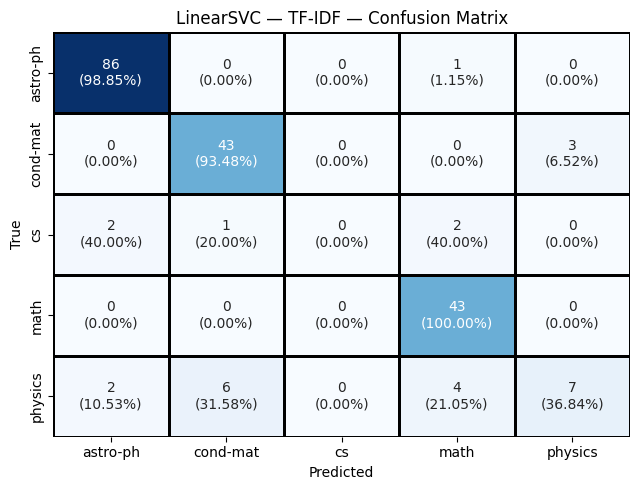

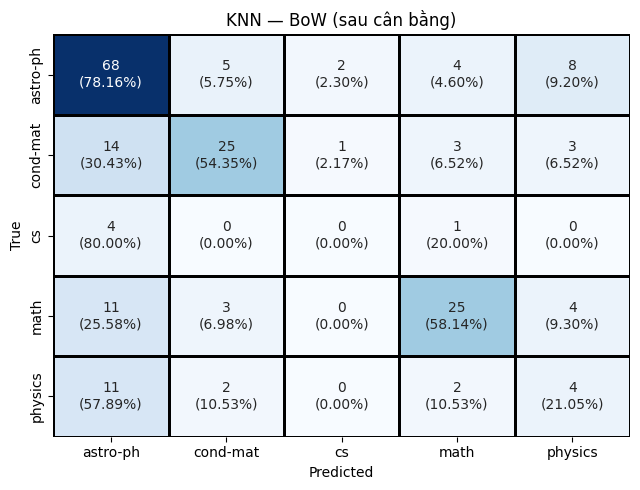

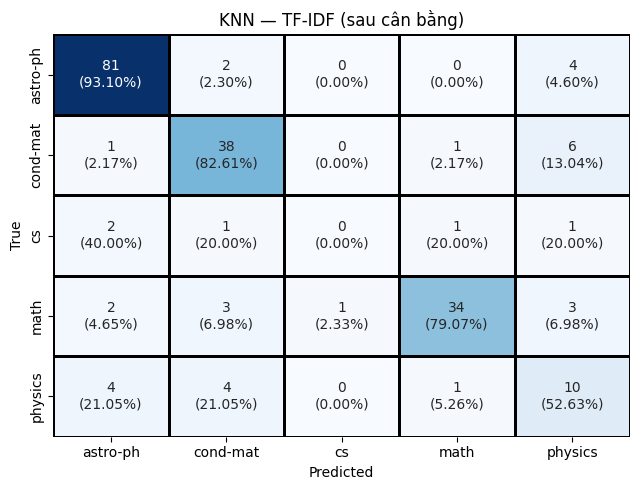

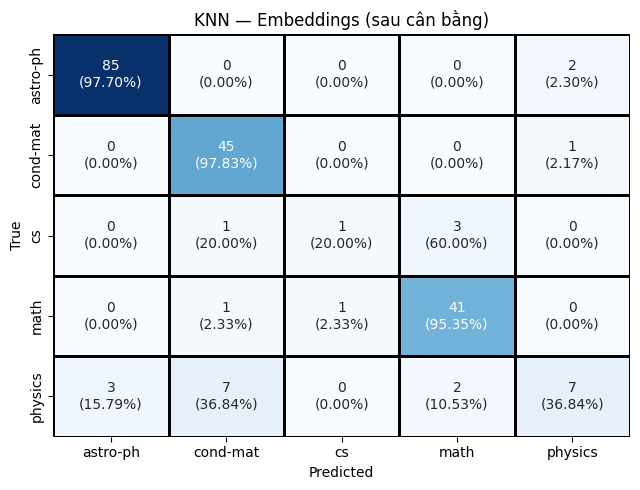

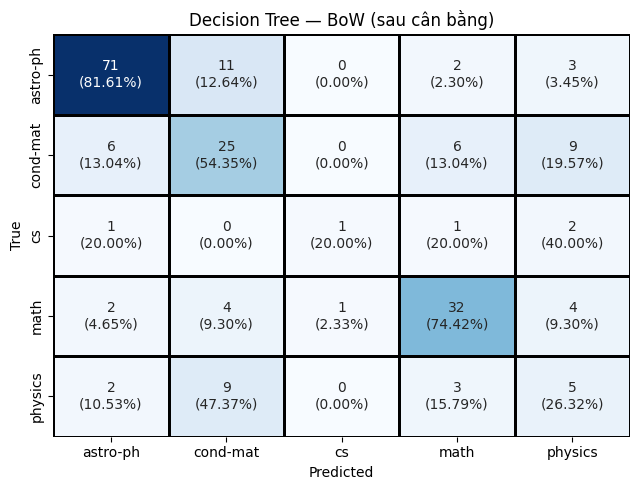

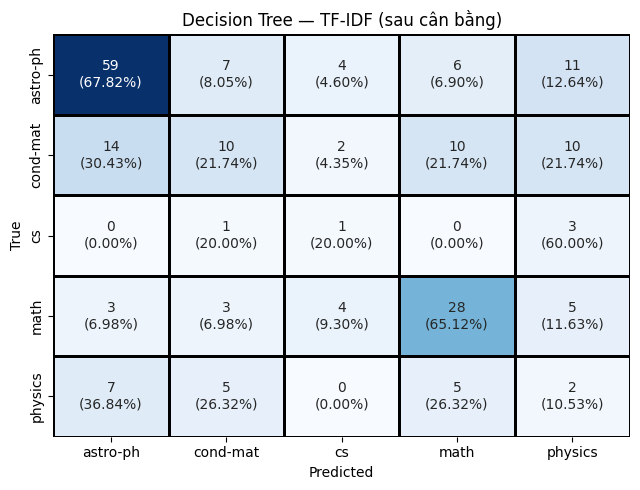

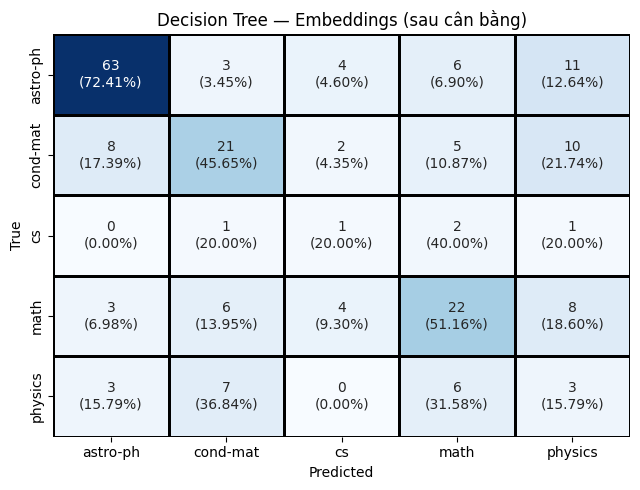

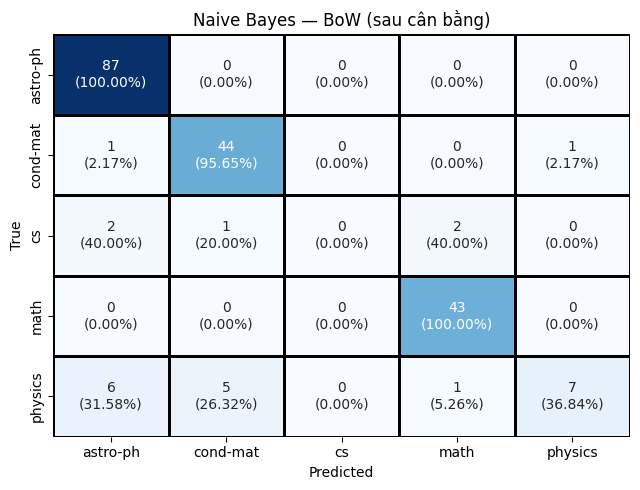

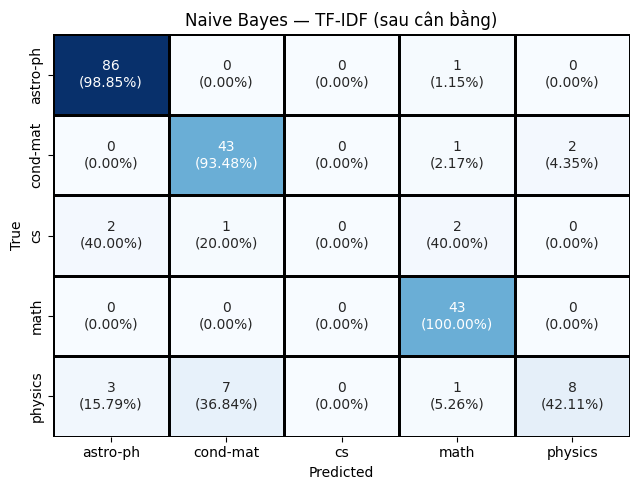

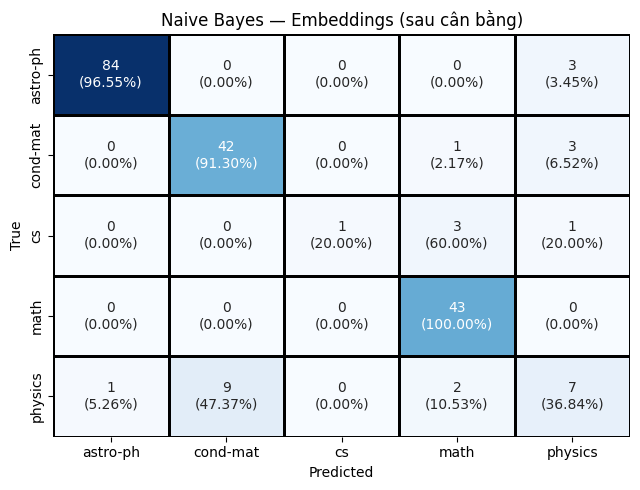

üèÜ Top: Ridge ‚Äî Embeddings | Acc=0.9200 | F1-macro=0.8242
üìÅ Confusion Matrix ƒë√£ l∆∞u v√†o:
 - pdf/Figures/all_models (t·∫•t c·∫£ m√¥ h√¨nh)
 - pdf/Figures/balanced (so s√°nh c√¢n b·∫±ng)
üíæ ƒê√£ l∆∞u: all_models_metrics.csv


In [43]:
# # ---- Chu·∫©n b·ªã nh√£n hi·ªÉn th·ªã ----
# assert 'y_test' in globals(), "C·∫ßn c√≥ y_test t·ª´ b∆∞·ªõc split d·ªØ li·ªáu."
# if 'sorted_labels' not in globals():
#     uniq = sorted(set(y_test))
#     sorted_labels = [str(i) for i in uniq]
# labels_idx = list(range(len(sorted_labels)))

# # ---- Helper v·∫Ω Confusion (t·∫°o n·∫øu ch∆∞a c√≥) ----
# def _cm_annot(cm: np.ndarray) -> np.ndarray:
#     cmn = cm.astype(float) / np.clip(cm.sum(axis=1, keepdims=True), 1, None)
#     ann = np.empty_like(cm).astype(str)
#     for i in range(cm.shape[0]):
#         for j in range(cm.shape[1]):
#             ann[i, j] = f"{cm[i, j]}\n({cmn[i, j]:.2%})"
#     return ann


# # 1) Thu th·∫≠p d·ª± ƒëo√°n m·ªçi m√¥ h√¨nh
# ALL_CANDIDATES = [
#     # KNN
#     ("KNN ‚Äî BoW", "knn_bow_labels"),
#     ("KNN ‚Äî TF-IDF", "knn_tfidf_labels"),
#     ("KNN ‚Äî Embeddings", "knn_emb_labels"),
#     # Decision Tree
#     ("Decision Tree ‚Äî BoW", "dt_bow_labels"),
#     ("Decision Tree ‚Äî TF-IDF", "dt_tfidf_labels"),
#     ("Decision Tree ‚Äî Embeddings", "dt_emb_labels"),
#     # Naive Bayes
#     ("Naive Bayes ‚Äî BoW", "nb_bow_labels"),
#     ("Naive Bayes ‚Äî TF-IDF", "nb_tfidf_labels"),
#     ("Naive Bayes ‚Äî Embeddings", "nb_emb_labels"),
#     # LinearSVC
#     ("LinearSVC ‚Äî BoW", "svc_bow_labels"),
#     ("LinearSVC ‚Äî TF-IDF", "svc_tfidf_labels"),
#     ("LinearSVC ‚Äî Embeddings", "svc_emb_labels"),
#     # Logistic Regression
#     ("LogReg ‚Äî BoW", "log_bow_labels"),
#     ("LogReg ‚Äî TF-IDF", "log_tfidf_labels"),
#     ("LogReg ‚Äî Embeddings", "log_emb_labels"),
#     # Ridge
#     ("Ridge ‚Äî BoW", "ridge_bow_labels"),
#     ("Ridge ‚Äî TF-IDF", "ridge_tfidf_labels"),
#     ("Ridge ‚Äî Embeddings", "ridge_emb_labels"),
# ]

# pred_map = {}
# missing = []
# for disp, var in ALL_CANDIDATES:
#     if var in globals():
#         pred_map[disp] = globals()[var]
#     else:
#         missing.append(disp)

# if not pred_map:
#     raise RuntimeError("Kh√¥ng t√¨m th·∫•y bi·∫øn d·ª± ƒëo√°n n√†o. H√£y ch·∫°y cell hu·∫•n luy·ªán ƒë·ªÉ t·∫°o c√°c *_labels tr∆∞·ªõc.")

# if missing:
#     print("‚ÑπÔ∏è Ch∆∞a c√≥ d·ª± ƒëo√°n cho:", ", ".join(missing))

# # 2) B·∫£ng t·ªïng h·ª£p metrics
# rows = []
# for name, y_pred in pred_map.items():
#     acc = accuracy_score(y_test, y_pred)
#     f1m = f1_score(y_test, y_pred, average="macro")
#     f1w = f1_score(y_test, y_pred, average="weighted")
#     algo, repr_ = name.split(" ‚Äî ")
#     rows.append({
#         "model_feature": name,
#         "algo": algo,
#         "repr": repr_,
#         "accuracy": acc,
#         "f1_macro": f1m,
#         "f1_weighted": f1w
#     })

# results_df_all = (pd.DataFrame(rows)
#                   .sort_values(["f1_macro","accuracy"], ascending=False)
#                   .reset_index(drop=True))

# print("üèÅ B·∫£ng t·ªïng h·ª£p (top 12 theo F1-macro):")
# try:
#     from IPython.display import display
#     display(results_df_all.head(12))
# except Exception:
#     print(results_df_all.head(12))

# # 3) Bi·ªÉu ƒë·ªì t·ªïng h·ª£p
# plt.figure(figsize=(10, 5))
# sns.barplot(data=results_df_all, x="model_feature", y="f1_macro",
#             order=results_df_all["model_feature"])
# plt.xticks(rotation=30, ha="right")
# plt.ylabel("F1-macro"); plt.title("F1-macro theo m√¥ h√¨nh‚Äìbi·ªÉu di·ªÖn")
# plt.tight_layout(); plt.show()

# plt.figure(figsize=(10, 5))
# sns.barplot(data=results_df_all, x="model_feature", y="accuracy",
#             order=results_df_all["model_feature"])
# plt.xticks(rotation=30, ha="right")
# plt.ylabel("Accuracy"); plt.title("Accuracy theo m√¥ h√¨nh‚Äìbi·ªÉu di·ªÖn")
# plt.tight_layout(); plt.show()

# # Bi·ªÉu ƒë·ªì theo t·ª´ng bi·ªÉu di·ªÖn
# for repr_name in ["BoW", "TF-IDF", "Embeddings"]:
#     sub = results_df_all[results_df_all["repr"] == repr_name].copy()
#     if sub.empty:
#         continue
#     plt.figure(figsize=(7.5, 4))
#     sns.barplot(data=sub, x="algo", y="f1_macro",
#                 order=sub.sort_values("f1_macro", ascending=False)["algo"])
#     plt.title(f"F1-macro ‚Äî {repr_name}")
#     plt.xlabel("M√¥ h√¨nh"); plt.ylabel("F1-macro")
#     plt.tight_layout(); plt.show()

# # 4) L∆∞u Confusion Matrix cho T·∫§T C·∫¢ m√¥ h√¨nh
# def _save_cm(y_true, y_pred, title, save_dir, fname_stub, show=True):
#     cm = confusion_matrix(y_true, y_pred, labels=labels_idx)
#     ann = _cm_annot(cm)
#     plt.figure(figsize=(6.5, 5))
#     sns.heatmap(cm, annot=ann, fmt="", cmap="Blues",
#                 xticklabels=sorted_labels, yticklabels=sorted_labels,
#                 cbar=False, linewidths=1, linecolor='black')
#     plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
#     plt.tight_layout()
#     fn = re.sub(r"[^a-zA-Z0-9\-_.]+", "_", fname_stub) + "_cm.pdf"
#     path = os.path.join(save_dir, fn)   # <-- d√πng tham s·ªë save_dir
#     plt.savefig(path, bbox_inches="tight")
#     if show:
#         plt.show()
#     else:
#         plt.close()

# # Hi·ªÉn th·ªã t·ªëi ƒëa N h√¨nh t·ªët nh·∫•t; ph·∫ßn c√≤n l·∫°i ch·ªâ l∆∞u
# SHOW_TOP_N = 9
# order_names = results_df_all["model_feature"].tolist()
# for i, name in enumerate(order_names):
#     _save_cm(y_test, pred_map[name], title=f"{name} ‚Äî Confusion Matrix",
#              save_dir=PATHS.all_models, fname_stub=name, show=(i < SHOW_TOP_N))

# if 'sorted_labels' not in globals():
#     assert 'y_test' in globals(), "C·∫ßn y_test ƒë·ªÉ suy ra nh√£n."
#     uniq = sorted(set(y_test))
#     sorted_labels = [str(i) for i in uniq]
# labels_idx = list(range(len(sorted_labels)))

# if '_cm_annot' not in globals():
#     def _cm_annot(cm: np.ndarray) -> np.ndarray:
#         cmn = cm.astype(float) / np.clip(cm.sum(axis=1, keepdims=True), 1, None)
#         ann = np.empty_like(cm).astype(str)
#         for i in range(cm.shape[0]):
#             for j in range(cm.shape[1]):
#                 ann[i, j] = f"{cm[i, j]}\n({cmn[i, j]:.2%})"
#         return ann

# if 'plot_confusion_single' not in globals():
#     def plot_confusion_single(y_true, y_pred, class_names=None, title="", save_path=None):
#         if class_names is None:
#             class_names = sorted_labels
#         cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
#         ann = _cm_annot(cm)
#         plt.figure(figsize=(6.5, 5))
#         sns.heatmap(cm, annot=ann, fmt="", cmap="Blues",
#                     xticklabels=class_names, yticklabels=class_names,
#                     cbar=False, linewidths=1, linecolor='black')
#         plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
#         plt.tight_layout()
#         if save_path:
#             plt.savefig(save_path, bbox_inches="tight")
#         plt.show()

# if 'compare_confusions' not in globals():
#     def compare_confusions(y_true, y_pred_pre, y_pred_post, class_names=None,
#                            title_pre="Tr∆∞·ªõc c√¢n b·∫±ng", title_post="Sau c√¢n b·∫±ng",
#                            save_path=None):
#         if class_names is None:
#             class_names = sorted_labels
#         labels = range(len(class_names))
#         cm_pre  = confusion_matrix(y_true, y_pred_pre,  labels=labels)
#         cm_post = confusion_matrix(y_true, y_pred_post, labels=labels)
#         ann_pre, ann_post = _cm_annot(cm_pre), _cm_annot(cm_post)

#         fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharex=True, sharey=True)
#         sns.heatmap(cm_pre,  annot=ann_pre,  fmt="", cmap="Blues",
#                     xticklabels=class_names, yticklabels=class_names,
#                     cbar=False, linewidths=1, linecolor='black', ax=axes[0])
#         axes[0].set_title(title_pre); axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")

#         sns.heatmap(cm_post, annot=ann_post, fmt="", cmap="Blues",
#                     xticklabels=class_names, yticklabels=class_names,
#                     cbar=False, linewidths=1, linecolor='black', ax=axes[1])
#         axes[1].set_title(title_post); axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("")
#         plt.tight_layout()
#         if save_path:
#             plt.savefig(save_path, bbox_inches="tight")
#         plt.show()


# # 5) GI·ªÆ L·∫†I KH·ªêI V·∫º TR∆Ø·ªöC/SAU C√ÇN B·∫∞NG (KNN/DT/NB)
# # ====== V·∫º KNN ======
# if 'knn_bow_labels_pre' in globals():
#     compare_confusions(y_test, knn_bow_labels_pre, knn_bow_labels,
#                        sorted_labels,
#                        title_pre="KNN-BoW (tr∆∞·ªõc c√¢n b·∫±ng)", title_post="KNN-BoW (sau c√¢n b·∫±ng)",
#                        save_path=os.path.join(PATHS.balanced, "knn_bow_compare.pdf"))
# else:
#     plot_confusion_single(y_test, knn_bow_labels, sorted_labels,
#                           "KNN ‚Äî BoW (sau c√¢n b·∫±ng)",
#                           save_path=os.path.join(PATHS.balanced, "knn_bow_balanced_cm.pdf"))

# if 'knn_tfidf_labels_pre' in globals():
#     compare_confusions(y_test, knn_tfidf_labels_pre, knn_tfidf_labels,
#                        sorted_labels,
#                        title_pre="KNN-TF-IDF (tr∆∞·ªõc c√¢n b·∫±ng)", title_post="KNN-TF-IDF (sau c√¢n b·∫±ng)",
#                        save_path=os.path.join(PATHS.balanced, "knn_tfidf_compare.pdf"))
# else:
#     plot_confusion_single(y_test, knn_tfidf_labels, sorted_labels,
#                           "KNN ‚Äî TF-IDF (sau c√¢n b·∫±ng)",
#                           save_path=os.path.join(PATHS.balanced, "knn_tfidf_balanced_cm.pdf"))

# if 'knn_emb_labels_pre' in globals():
#     compare_confusions(y_test, knn_emb_labels_pre, knn_emb_labels,
#                        sorted_labels,
#                        title_pre="KNN-Emb (tr∆∞·ªõc c√¢n b·∫±ng)", title_post="KNN-Emb (sau c√¢n b·∫±ng)",
#                        save_path=os.path.join(PATHS.balanced, "knn_emb_compare.pdf"))
# else:
#     plot_confusion_single(y_test, knn_emb_labels, sorted_labels,
#                           "KNN ‚Äî Embeddings (sau c√¢n b·∫±ng)",
#                           save_path=os.path.join(PATHS.balanced, "knn_emb_balanced_cm.pdf"))

# # ====== V·∫º Decision Tree ======
# if 'dt_bow_labels_pre' in globals():
#     compare_confusions(y_test, dt_bow_labels_pre, dt_bow_labels,
#                        sorted_labels,
#                        title_pre="DT-BoW (tr∆∞·ªõc c√¢n b·∫±ng)", title_post="DT-BoW (sau c√¢n b·∫±ng)",
#                        save_path=os.path.join(PATHS.balanced, "dt_bow_compare.pdf"))
# else:
#     plot_confusion_single(y_test, dt_bow_labels, sorted_labels,
#                           "Decision Tree ‚Äî BoW (sau c√¢n b·∫±ng)",
#                           save_path=os.path.join(PATHS.balanced, "dt_bow_balanced_cm.pdf"))

# if 'dt_tfidf_labels_pre' in globals():
#     compare_confusions(y_test, dt_tfidf_labels_pre, dt_tfidf_labels,
#                        sorted_labels,
#                        title_pre="DT-TF-IDF (tr∆∞·ªõc c√¢n b·∫±ng)", title_post="DT-TF-IDF (sau c√¢n b·∫±ng)",
#                        save_path=os.path.join(PATHS.balanced, "dt_tfidf_compare.pdf"))
# else:
#     plot_confusion_single(y_test, dt_tfidf_labels, sorted_labels,
#                           "Decision Tree ‚Äî TF-IDF (sau c√¢n b·∫±ng)",
#                           save_path=os.path.join(PATHS.balanced, "dt_tfidf_balanced_cm.pdf"))

# if 'dt_emb_labels_pre' in globals():
#     compare_confusions(y_test, dt_emb_labels_pre, dt_emb_labels,
#                        sorted_labels,
#                        title_pre="DT-Emb (tr∆∞·ªõc c√¢n b·∫±ng)", title_post="DT-Emb (sau c√¢n b·∫±ng)",
#                        save_path=os.path.join(PATHS.balanced, "dt_emb_compare.pdf"))
# else:
#     plot_confusion_single(y_test, dt_emb_labels, sorted_labels,
#                           "Decision Tree ‚Äî Embeddings (sau c√¢n b·∫±ng)",
#                           save_path=os.path.join(PATHS.balanced, "dt_emb_balanced_cm.pdf"))

# # ====== V·∫º Naive Bayes ======
# if 'nb_bow_labels_pre' in globals():
#     compare_confusions(y_test, nb_bow_labels_pre, nb_bow_labels,
#                        sorted_labels,
#                        title_pre="NB-BoW (tr∆∞·ªõc c√¢n b·∫±ng)", title_post="NB-BoW (sau c√¢n b·∫±ng)",
#                        save_path=os.path.join(PATHS.balanced, "nb_bow_compare.pdf"))
# else:
#     plot_confusion_single(y_test, nb_bow_labels, sorted_labels,
#                           "Naive Bayes ‚Äî BoW (sau c√¢n b·∫±ng)",
#                           save_path=os.path.join(PATHS.balanced, "nb_bow_balanced_cm.pdf"))

# if 'nb_tfidf_labels_pre' in globals():
#     compare_confusions(y_test, nb_tfidf_labels_pre, nb_tfidf_labels,
#                        sorted_labels,
#                        title_pre="NB-TF-IDF (tr∆∞·ªõc c√¢n b·∫±ng)", title_post="NB-TF-IDF (sau c√¢n b·∫±ng)",
#                        save_path=os.path.join(PATHS.balanced, "nb_tfidf_compare.pdf"))
# else:
#     plot_confusion_single(y_test, nb_tfidf_labels, sorted_labels,
#                           "Naive Bayes ‚Äî TF-IDF (sau c√¢n b·∫±ng)",
#                           save_path=os.path.join(PATHS.balanced, "nb_tfidf_balanced_cm.pdf"))

# if 'nb_emb_labels_pre' in globals():
#     compare_confusions(y_test, nb_emb_labels_pre, nb_emb_labels,
#                        sorted_labels,
#                        title_pre="NB-Emb (tr∆∞·ªõc c√¢n b·∫±ng)", title_post="NB-Emb (sau c√¢n b·∫±ng)",
#                        save_path=os.path.join(PATHS.balanced, "nb_emb_compare.pdf"))
# else:
#     plot_confusion_single(y_test, nb_emb_labels, sorted_labels,
#                           "Naive Bayes ‚Äî Embeddings (sau c√¢n b·∫±ng)",
#                           save_path=os.path.join(PATHS.balanced, "nb_emb_balanced_cm.pdf"))

# # 6) L∆∞u CSV & K·∫øt lu·∫≠n nhanh
# csv_path = "all_models_metrics.csv"
# results_df_all.to_csv(csv_path, index=False)
# lead = results_df_all.iloc[0]
# print(f"üèÜ Top: {lead['model_feature']} | Acc={lead['accuracy']:.4f} | F1-macro={lead['f1_macro']:.4f}")
# print(f"üìÅ Confusion Matrix ƒë√£ l∆∞u v√†o:\n - {PATHS.all_models} (t·∫•t c·∫£ m√¥ h√¨nh)\n - {PATHS.balanced} (so s√°nh c√¢n b·∫±ng)")
# print(f"üíæ ƒê√£ l∆∞u: {csv_path}")

#**Streamlit**

In [45]:
# 1) L∆∞u b·∫£ng t·ªïng h·ª£p
results_df_all.to_csv("results_summary.csv", index=False)

# 2) L∆∞u mapping nh√£n
with open("id_to_label.json","w") as f:
    json.dump(id_to_label, f)            # keys s·∫Ω l√† str trong JSON
with open("sorted_labels.json","w") as f:
    json.dump(sorted_labels, f)

# 3) Ch·ªçn model t·ªët nh·∫•t
best = results_df_all.iloc[0]
best_name = best["model_feature"]
algo_name, feature_name = [x.strip() for x in best_name.split("‚Äî")]
feature_name = feature_name.lower()

# map t√™n ‚Üí model
def build_model(name):
    if name.startswith("LinearSVC"):   return LinearSVC(C=1.0, class_weight='balanced', random_state=42)
    if name.startswith("LogReg"):      return LogisticRegression(C=1.0, penalty='l2', solver='lbfgs',
                                                                 max_iter=2000, class_weight='balanced',
                                                                 random_state=42)
    if name.startswith("Ridge"):       return RidgeClassifier(alpha=1.0, class_weight='balanced', random_state=42)
    if name.startswith("KNN"):         return KNeighborsClassifier(n_neighbors=5)
    if name.startswith("Decision Tree"): return DecisionTreeClassifier(random_state=42, class_weight='balanced')
    if name.startswith("Naive Bayes"): return GaussianNB()
    raise ValueError(f"Kh√¥ng nh·∫≠n ra model: {name}")

# 4) L·∫•y ƒë√∫ng t·∫≠p train ƒë√£ c√¢n b·∫±ng theo feature + l∆∞u vectorizer n·∫øu c·∫ßn
if feature_name in ("bow",):
    Xtr, ytr = X_train_bow_bal,  y_train_bow_bal
    joblib.dump(bow_vectorizer, "bow_vectorizer.joblib")
elif feature_name in ("tf-idf","tfidf"):
    Xtr, ytr = X_train_tfidf_bal, y_train_tfidf_bal
    joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.joblib")
else:
    feature_name = "embeddings"
    Xtr, ytr = X_train_emb_bal,  y_train_emb_bal

# 5) Train l·∫°i model best tr√™n full t·∫≠p train t∆∞∆°ng ·ª©ng r·ªìi l∆∞u
best_model = build_model(algo_name)
if isinstance(best_model, GaussianNB):
    Xtr = Xtr.toarray() if hasattr(Xtr, "toarray") else Xtr
best_model.fit(Xtr, ytr)
joblib.dump(best_model, "best_model.joblib")

# 6) L∆∞u metadata ƒë·ªÉ app bi·∫øt ph·∫£i d√πng g√¨ l√∫c suy lu·∫≠n
meta = {
    "feature": feature_name,
    "model_feature": best_name,
    "emb_model": "intfloat/multilingual-e5-base"   # t√™n SentenceTransformer d√πng cho embeddings
}
with open("best_meta.json","w") as f:
    json.dump(meta, f)

# 7) L∆∞u y_test + to√†n b·ªô d·ª± ƒëo√°n ƒë·ªÉ app v·∫Ω heatmap (DUY NH·∫§T 1 L·∫¶N)
np.save("y_test.npy", np.asarray(y_test, dtype=int))
VAR_MAP = {
    "KNN ‚Äî BoW": "knn_bow_labels",
    "KNN ‚Äî TF-IDF": "knn_tfidf_labels",
    "KNN ‚Äî Embeddings": "knn_emb_labels",
    "Decision Tree ‚Äî BoW": "dt_bow_labels",
    "Decision Tree ‚Äî TF-IDF": "dt_tfidf_labels",
    "Decision Tree ‚Äî Embeddings": "dt_emb_labels",
    "Naive Bayes ‚Äî BoW": "nb_bow_labels",
    "Naive Bayes ‚Äî TF-IDF": "nb_tfidf_labels",
    "Naive Bayes ‚Äî Embeddings": "nb_emb_labels",
    "LinearSVC ‚Äî BoW": "svc_bow_labels",
    "LinearSVC ‚Äî TF-IDF": "svc_tfidf_labels",
    "LinearSVC ‚Äî Embeddings": "svc_emb_labels",
    "LogReg ‚Äî BoW": "log_bow_labels",
    "LogReg ‚Äî TF-IDF": "log_tfidf_labels",
    "LogReg ‚Äî Embeddings": "log_emb_labels",
    "Ridge ‚Äî BoW": "ridge_bow_labels",
    "Ridge ‚Äî TF-IDF": "ridge_tfidf_labels",
    "Ridge ‚Äî Embeddings": "ridge_emb_labels",
}
preds = {disp: np.asarray(globals()[var], dtype=int).tolist()
         for disp, var in VAR_MAP.items() if var in globals()}
with open("preds.json","w") as f:
    json.dump(preds, f)

print("‚úÖ Saved: results_summary.csv, id_to_label.json, best_model.joblib, best_meta.json, preds.json, y_test.npy (+ vectorizer n·∫øu c·∫ßn)")
print("üèÜ Best:", best_name)

# ---------- app.py ----------
app_code = r"""
import os
import json, joblib, numpy as np, pandas as pd
import streamlit as st
import plotly.express as px
from sentence_transformers import SentenceTransformer

st.set_page_config(page_title='Model Leaderboard', layout='wide')

# ---------- Load d·ªØ li·ªáu ----------
df = pd.read_csv('results_summary.csv')
meta = json.load(open('best_meta.json'))
id_to_label = json.load(open('id_to_label.json'))
id_to_label = {int(k): v for k, v in id_to_label.items()}

sorted_labels = json.load(open('sorted_labels.json'))
preds_map = json.load(open('preds.json')) if os.path.exists('preds.json') else {}
y_test_arr = np.load('y_test.npy') if os.path.exists('y_test.npy') else np.array([])

if not preds_map or y_test_arr.size == 0:
    st.warning("Ch∆∞a c√≥ `preds.json` ho·∫∑c `y_test.npy`. H√£y ch·∫°y block xu·∫•t d·ª± ƒëo√°n trong notebook tr∆∞·ªõc khi m·ªü app.")
    st.stop()

st.title('üìä NLP Leaderboard & Inference Demo')

# ---------- Layout: tr√°i (F1/Acc/Leaderboard) ‚Äî ph·∫£i (Confusion Matrix) ----------
col_left, col_right = st.columns([1.3, 1])

with col_left:
    st.subheader('üìà Th·ªëng k√™')
    tabs = st.tabs(['F1-macro (higher is better)', 'Accuracy', 'Leaderboard table'])

    import plotly.express as px
    with tabs[0]:
        fig1 = px.bar(df, x='model_feature', y='f1_macro', hover_data=['accuracy'])
        fig1.update_layout(xaxis_tickangle=-45, margin=dict(l=10, r=10, t=30, b=10), height=420)
        st.plotly_chart(fig1, use_container_width=True)

    with tabs[1]:
        fig2 = px.bar(df, x='model_feature', y='accuracy')
        fig2.update_layout(xaxis_tickangle=-45, margin=dict(l=10, r=10, t=30, b=10), height=420)
        st.plotly_chart(fig2, use_container_width=True)

    with tabs[2]:
        st.dataframe(
            df.style.format({'accuracy': '{:.4f}', 'f1_macro': '{:.4f}', 'f1_weighted': '{:.4f}'}),
            use_container_width=True, height=420
        )

with col_right:
    st.subheader('üìå Ch·ªçn m√¥ h√¨nh & xem Confusion Matrix')
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    model_opt = st.selectbox('M√¥ h√¨nh', list(preds_map.keys()), index=0)
    normalize = st.checkbox('Chu·∫©n h√≥a theo h√†ng (%)', value=True)

    y_pred_app = np.array(preds_map[model_opt], dtype=int)
    cm = confusion_matrix(y_test_arr, y_pred_app, labels=list(range(len(sorted_labels))))
    if normalize:
        row_sums = cm.sum(axis=1, keepdims=True).clip(min=1)
        cm_show = (cm / row_sums) * 100.0
        fmt = '.1f'
    else:
        cm_show = cm
        fmt = 'd'

    fig, ax = plt.subplots(figsize=(6.5, 5.2))
    sns.heatmap(cm_show, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=sorted_labels, yticklabels=sorted_labels,
                cbar=False, linewidths=.5, linecolor='black', ax=ax)
    ax.set_xlabel('Predicted'); ax.set_ylabel('True'); ax.set_title(model_opt)
    st.pyplot(fig, use_container_width=True)

# ---------- Inference ----------
st.subheader('üîÆ ƒê·ªÅ xu·∫•t m√¥ h√¨nh t·ªët nh·∫•t & th·ª≠ d·ª± ƒëo√°n')
st.info(f"ƒê·ªÅ xu·∫•t: **{meta['model_feature']}**  |  Feature: `{meta['feature']}`")

text = st.text_area('Nh·∫≠p abstract/ƒëo·∫°n vƒÉn b·∫£n c·∫ßn ph√¢n lo·∫°i', height=160,
                    placeholder='Paste your text here...')
run = st.button('D·ª± ƒëo√°n')

if run and text.strip():
    model = joblib.load('best_model.joblib')
    feature = meta['feature']

    if feature == 'bow':
        vec = joblib.load('bow_vectorizer.joblib')
        X = vec.transform([text])
    elif feature in ('tf-idf', 'tfidf'):
        vec = joblib.load('tfidf_vectorizer.joblib')
        X = vec.transform([text])
    else:
        emb_model = meta.get('emb_model', 'intfloat/multilingual-e5-base')
        m = SentenceTransformer(emb_model)
        X = m.encode([f'query: {text}'], normalize_embeddings=True)
        X = np.array(X)

    if model.__class__.__name__ == 'GaussianNB':
        X = X.toarray() if hasattr(X, 'toarray') else X

    pred = int(model.predict(X)[0])
    st.success(f'K·∫øt qu·∫£: **{id_to_label[pred]}**')
"""
with open('app.py', 'w', encoding='utf-8') as f:
    f.write(app_code)

print("‚úÖ Created app.py")

# 1) ch·∫°y streamlit headless
!streamlit run app.py --server.port 8501 --server.headless true &> /content/streamlit.log &

# 2) t·∫£i cloudflared & m·ªü quick tunnel
!wget -q -O /content/cloudflared \
  https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x /content/cloudflared
!/content/cloudflared tunnel --url http://localhost:8501 --no-autoupdate > /content/cf.log 2>&1 &

# 3) l·∫•y public URL (ƒë·ª£i v√†i gi√¢y)
import time, re
for _ in range(20):
    time.sleep(1)
    log = open('/content/cf.log').read()
    m = re.search(r'https://[-0-9a-z]+\.trycloudflare\.com', log)
    if m:
        print("üîó Open this URL:", m.group(0))
        break
else:
    print("‚ö†Ô∏è Kh√¥ng th·∫•y URL, in log ƒë·ªÉ ki·ªÉm tra:\n", log[-2000:])


‚úÖ Saved: results_summary.csv, id_to_label.json, best_model.joblib, best_meta.json, preds.json, y_test.npy (+ vectorizer n·∫øu c·∫ßn)
üèÜ Best: Ridge ‚Äî Embeddings
‚úÖ Created app.py
/content/cloudflared: Text file busy
üîó Open this URL: https://shirts-e-sue-commercial.trycloudflare.com
